<h1>Prediction of customer churn for telecom operator TeleDom</h1>

Telecom operator TeleDom wants to combat customer outflow. To do this, its employees will begin to offer promotional codes and special conditions to everyone who plans to refuse communication services. To find such users in advance, TeleDom needs a model that will predict whether a subscriber will break the contract. The operator’s team collected personal data about some clients, information about their tariffs and services. The task is to train a model on this data to predict customer churn.

<b>Goals and objectives of the project</b>

The main goal of the project is to develop a machine learning model that can predict the likelihood of customer churn of the telecom operator TeleDom based on an analysis of their behavior and use of services.


Project objectives include:


- Analysis of provided data about clients and their use of services.<br>
- Data preprocessing to prepare for model training.<br>
- Selecting and training a machine learning model to predict churn. <br>
- Assessing the effectiveness of the model using appropriate metrics.<br>

Success criteria:<br>
  The project will be considered successful if the following indicators are achieved:

- AUC-ROC above 0.85.

# **Step 1: Loading data**






In [1]:
!pip install pyspark
!pip install phik
!pip install catboost
!pip install --upgrade scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import sklearn
import pickle
import typing
from typing import Dict, Any
from sklearn.preprocessing import OneHotEncoder
from pyspark.sql import SparkSession
from phik import resources, report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=8aba2a348ef6e6badf10c69c717a41b29db08e9efd6f787232801d2b6e10b50d
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 18.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
sns.set_palette('tab20c')

In [4]:
RANDOM_STATE=190224

In [5]:
#load datasets
contract = pd.read_csv('/content/drive/MyDrive/datasets/contract_new.csv')

display(contract.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [6]:
#size of dataset contract
contract.shape

(7043, 8)

In [7]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [8]:
print(contract.isnull().sum())

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


In [9]:
duplicate_count = contract.duplicated(subset='customerID', keep=False).sum()
print(duplicate_count)

0


Primary data analysis was conducted on the “contract” dataset. 7043 rows, 8 columns. Some data types should be modified to better suit the information they contain. Data should be checked for obvious and hidden duplicates.

In [10]:
#load dataset
internet = pd.read_csv('/content/drive/MyDrive/datasets/internet_new.csv')
display(internet.head())

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [11]:
#size of dataset internet
internet.shape

(5517, 8)

In [12]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [13]:
print(internet.isnull().sum())

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


In [14]:
duplicate_count = internet.duplicated(subset='customerID', keep=False).sum()
print(duplicate_count)

0


Primary data analysis was conducted on the Internet dataset. 5517 rows, 8 columns. Some data types should be modified to better suit the information they contain.

In [15]:
personal = pd.read_csv('/content/drive/MyDrive/datasets/personal_new.csv')
display(personal.head())

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [16]:
#size of dataset personal
personal.shape

(7043, 5)

In [17]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [18]:
print(personal.isnull().sum())

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64


In [19]:
duplicate_count = personal.duplicated(subset='customerID', keep=False).sum()
print(duplicate_count)

0


Primary data analysis was conducted on a “personal” data set. 7043 rows, 5 columns. Data types should be changed to better represent them in some information. Data should be checked for obvious and hidden duplicates.

In [20]:
phone = pd.read_csv('/content/drive/MyDrive/datasets/phone_new.csv')
display(phone.head())

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [21]:
#size of dataset phone
phone.shape

(6361, 2)

In [22]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [23]:
print(phone.isnull().sum())

customerID       0
MultipleLines    0
dtype: int64


In [24]:
duplicate_count = phone.duplicated(subset='customerID', keep=False).sum()
print(duplicate_count)

0


Initial data analysis was conducted on the “Phone” dataset. 6361 rows, 2 columns. No missing data. There are no duplicates by customerID

Data from 4 datasets were successfully loaded. The data must be pre-processed. This will be done in the next section.

# **Step 2. Exploratory data analysis and preprocessing**

## Dataset Contract















In this dataset, it is needed to perform the following steps for exploratory data analysis and preprocessing:<br>

-Translation of column names to lowercase, as this is common practice.  
-Search for obvious duplicates.
-Search for missing data.
-Removing obvious duplicates, if any
-Translation of date column format to datetime64 format  
-Translation of totalcharges into numeric format  
-If gaps are found in this column, this will mean that there are clients who have not yet paid a single fee, and therefore this data can be replaced with 0
-It is necessary to create a target variable - customer outflow - if they terminated the contract, the enddate column will indicate the end date of the contract  
-If the contract expiration date is not set, then the client continues to use the services, and you can replace the missing data with the date 2020-02-01 - contracts are valid until this date  
-For numerical data, analyze data scatter and outliers using the Boxplot graph  
-Carry out an analysis of the distribution of the target variable Churn  





In [25]:
#converting column names to lowercase
contract.columns = contract.columns.str.lower()

In [26]:
#looking for obvious duplicates
duplicates = contract.duplicated()
print(duplicates.sum())

0


In [27]:
#delete dublicates
contract = contract.drop_duplicates()
contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   begindate         7043 non-null   object 
 2   enddate           7043 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   monthlycharges    7043 non-null   float64
 7   totalcharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 495.2+ KB


In [28]:
# Convert 'begindate' and 'enddate' to datetime
contract['begindate'] = pd.to_datetime(contract['begindate'])
contract['enddate'] = pd.to_datetime(contract['enddate'], errors='coerce')

# Convert 'totalcharges' to numeric, errors='coerce' will replace non-numeric values with NaN
contract['totalcharges'] = pd.to_numeric(contract['totalcharges'], errors='coerce')

# Check the new data types
print(contract.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           1101 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 495.2+ KB
None


In [29]:
# Replacing all types of missing values with 0
contract['totalcharges'].fillna(0, inplace=True)

The found  totalcharges gaps presumably mean that there are clients who have not yet paid a single fee, and therefore this data can be replaced by 0

In [30]:
# Creating a target column 'churn' indicating whether a customer has churned
# 1 if 'end_date' has a date (the contract was terminated), 0 otherwise
contract['churn'] = contract['enddate'].notna().astype(int)

# Checking the distribution of the target variable
print(contract['churn'].value_counts())

0    5942
1    1101
Name: churn, dtype: int64


In [31]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           1101 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   float64       
 8   churn             7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 550.2+ KB


In [32]:
#replace missing end_date because the information in contracts is actual  to 2020-02-01
replacement_date = pd.Timestamp('2020-02-01')
contract['enddate'] = contract['enddate'].fillna(replacement_date)

In [33]:
contract.head(3)

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0


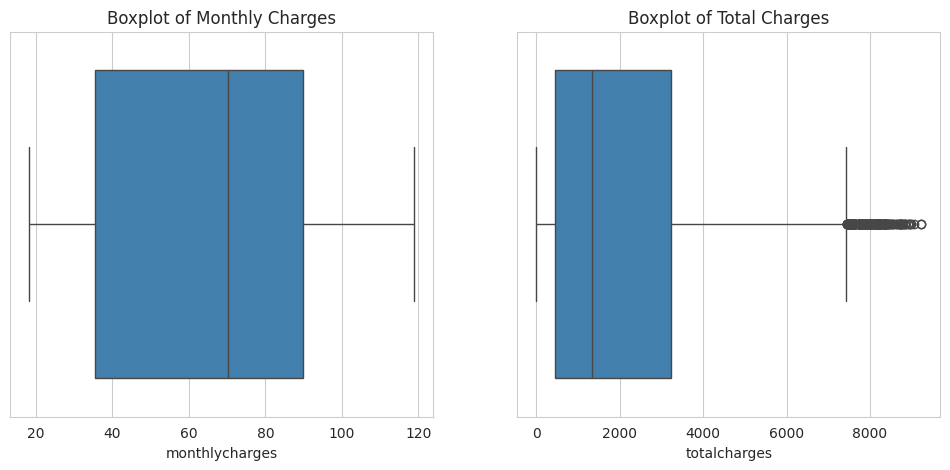

In [34]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Creating boxplots for 'monthlycharges' and 'totalcharges'
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=contract['monthlycharges'])
plt.title('Boxplot of Monthly Charges')

plt.subplot(1, 2, 2)
sns.boxplot(x=contract['totalcharges'])
plt.title('Boxplot of Total Charges')

plt.show()

An anomaly and outlier analysis was performed, with particular attention paid to the TotalCharges column. As a result of the analysis, it became clear that there was significant variation in the data, which may indicate the presence of long-term customers with high overall costs.

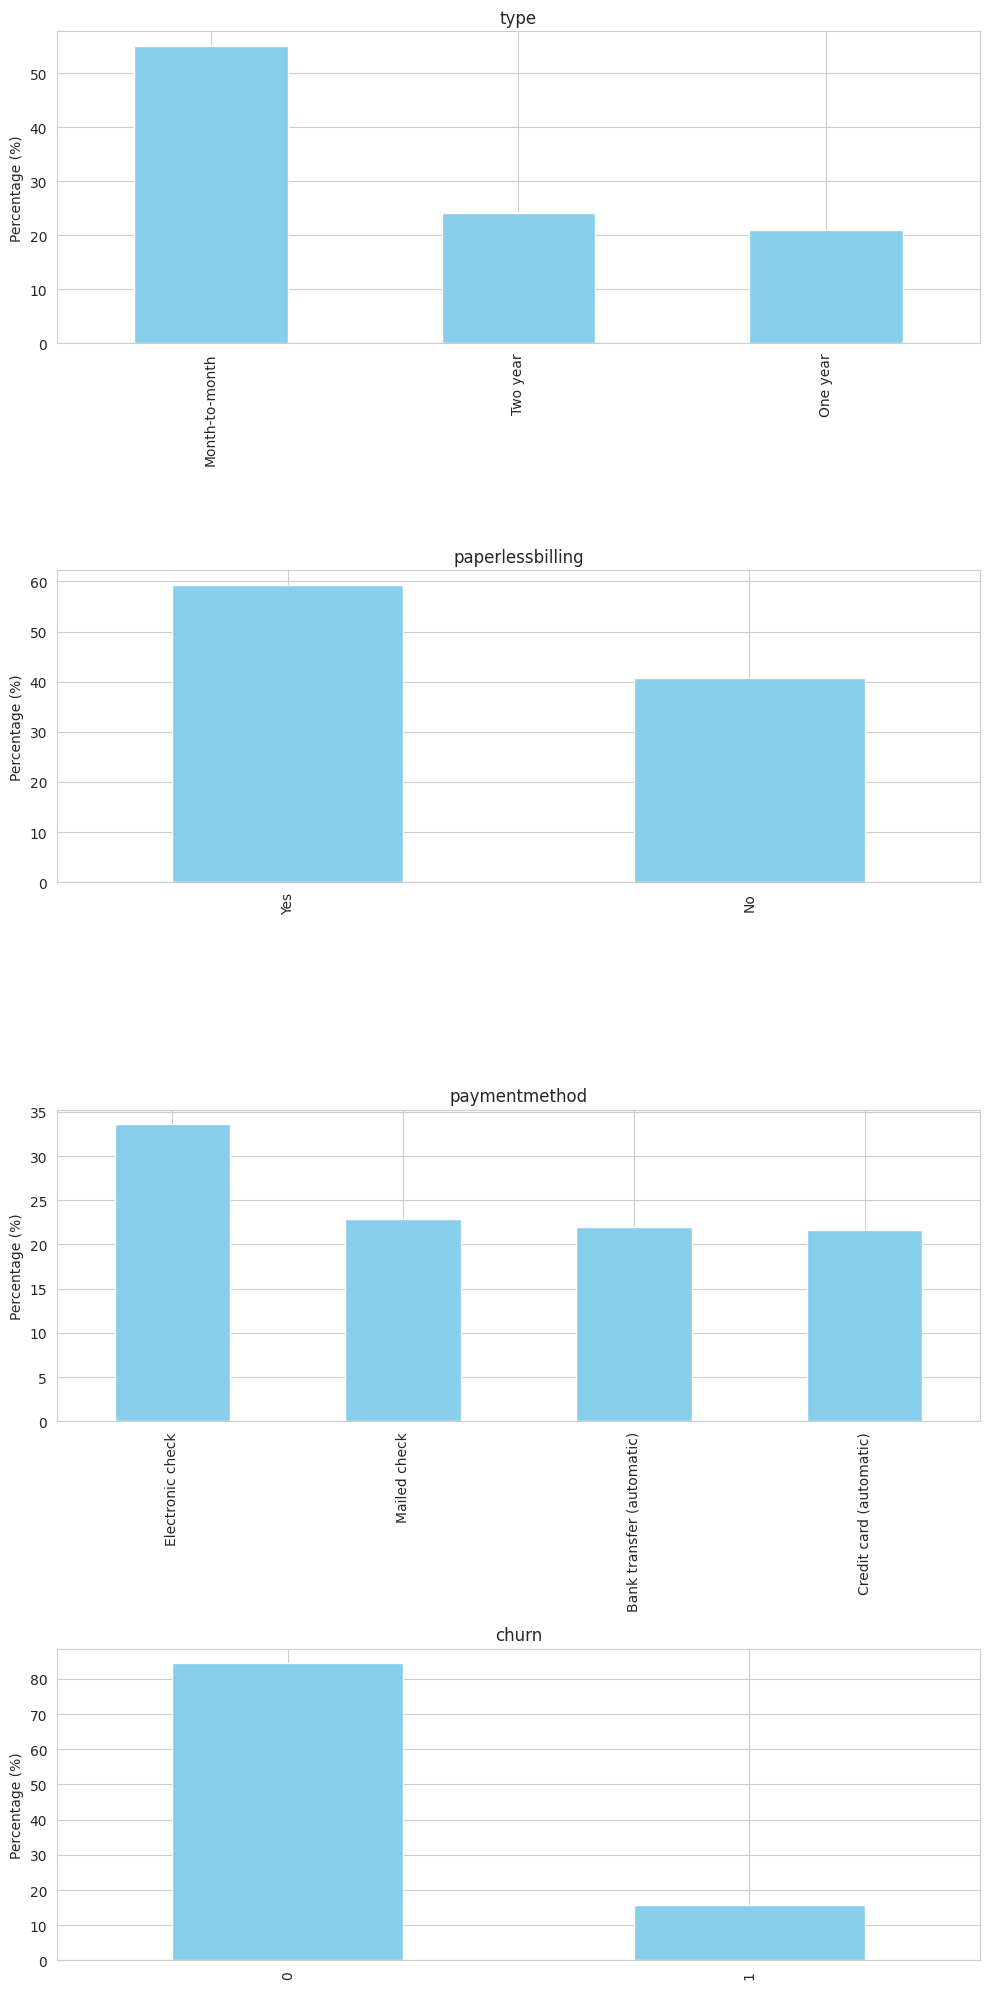

In [35]:
columns = ['type', 'paperlessbilling', 'paymentmethod', 'churn']

fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(10, 20))

for i, col in enumerate(columns):

    value_counts = contract[col].value_counts(normalize=True) * 100
    value_counts.plot(kind='bar', ax=axes[i], title=col, color='skyblue')
    axes[i].set_ylabel('Percentage (%)')
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

Among the types of contract payment, the predominant one is monthly

Electronic payment type predominates, the other 3 payment types occupy approximately the same proportions

More than half of clients request an electronic payslip.

In [36]:
contract['churn'].describe()

count    7043.000000
mean        0.156325
std         0.363189
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: churn, dtype: float64

As part of the “Exploratory analysis and pre-processing of data” section for the “Contract” data set, the following actions were performed and the corresponding conclusions were drawn:

Preliminary data check. The dataset was carefully screened for data types, missing values, and overall content. The data was found to contain both numeric and categorical characteristics, as well as missing values in the EndDate column.

Handling missing values. Missing values in EndDate were interpreted as indicators of ongoing contracts (customers continuing to use services). These values have been replaced by the date 02/01/2020 - the data in the contracts is valid until this date.

Anomaly analysis and processing. An anomaly and outlier analysis was performed, with particular attention paid to the TotalCharges column. As a result of the analysis, it became clear that there was significant variation in the data, which may indicate the presence of long-term customers with high overall costs.

Among contract payment types, monthly predominates. Electronic payslip is requested by more than half of clients. Electronic payment type prevails.

Analysis of the target variable: An analysis of the distribution of the target variable (customer churn) was carried out, which showed that about 15.63% of the customers terminated the contract. This provides the basis for further building a customer churn prediction model.

## Dataset **Internet**

In this dataset, the following steps must be performed for exploratory data analysis and preprocessing:<br> -Translating column names to lowercase, as this is common practice.
-Search for missing data
-Duplicates in this dataset do not require deletion, since the data in the columns is not personalized and may be the same for several clients
-Analyze the distribution of categorical data

In [37]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [38]:
#converting column names to lowercase
internet.columns = internet.columns.str.lower()

In [39]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerid        5517 non-null   object
 1   internetservice   5517 non-null   object
 2   onlinesecurity    5517 non-null   object
 3   onlinebackup      5517 non-null   object
 4   deviceprotection  5517 non-null   object
 5   techsupport       5517 non-null   object
 6   streamingtv       5517 non-null   object
 7   streamingmovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


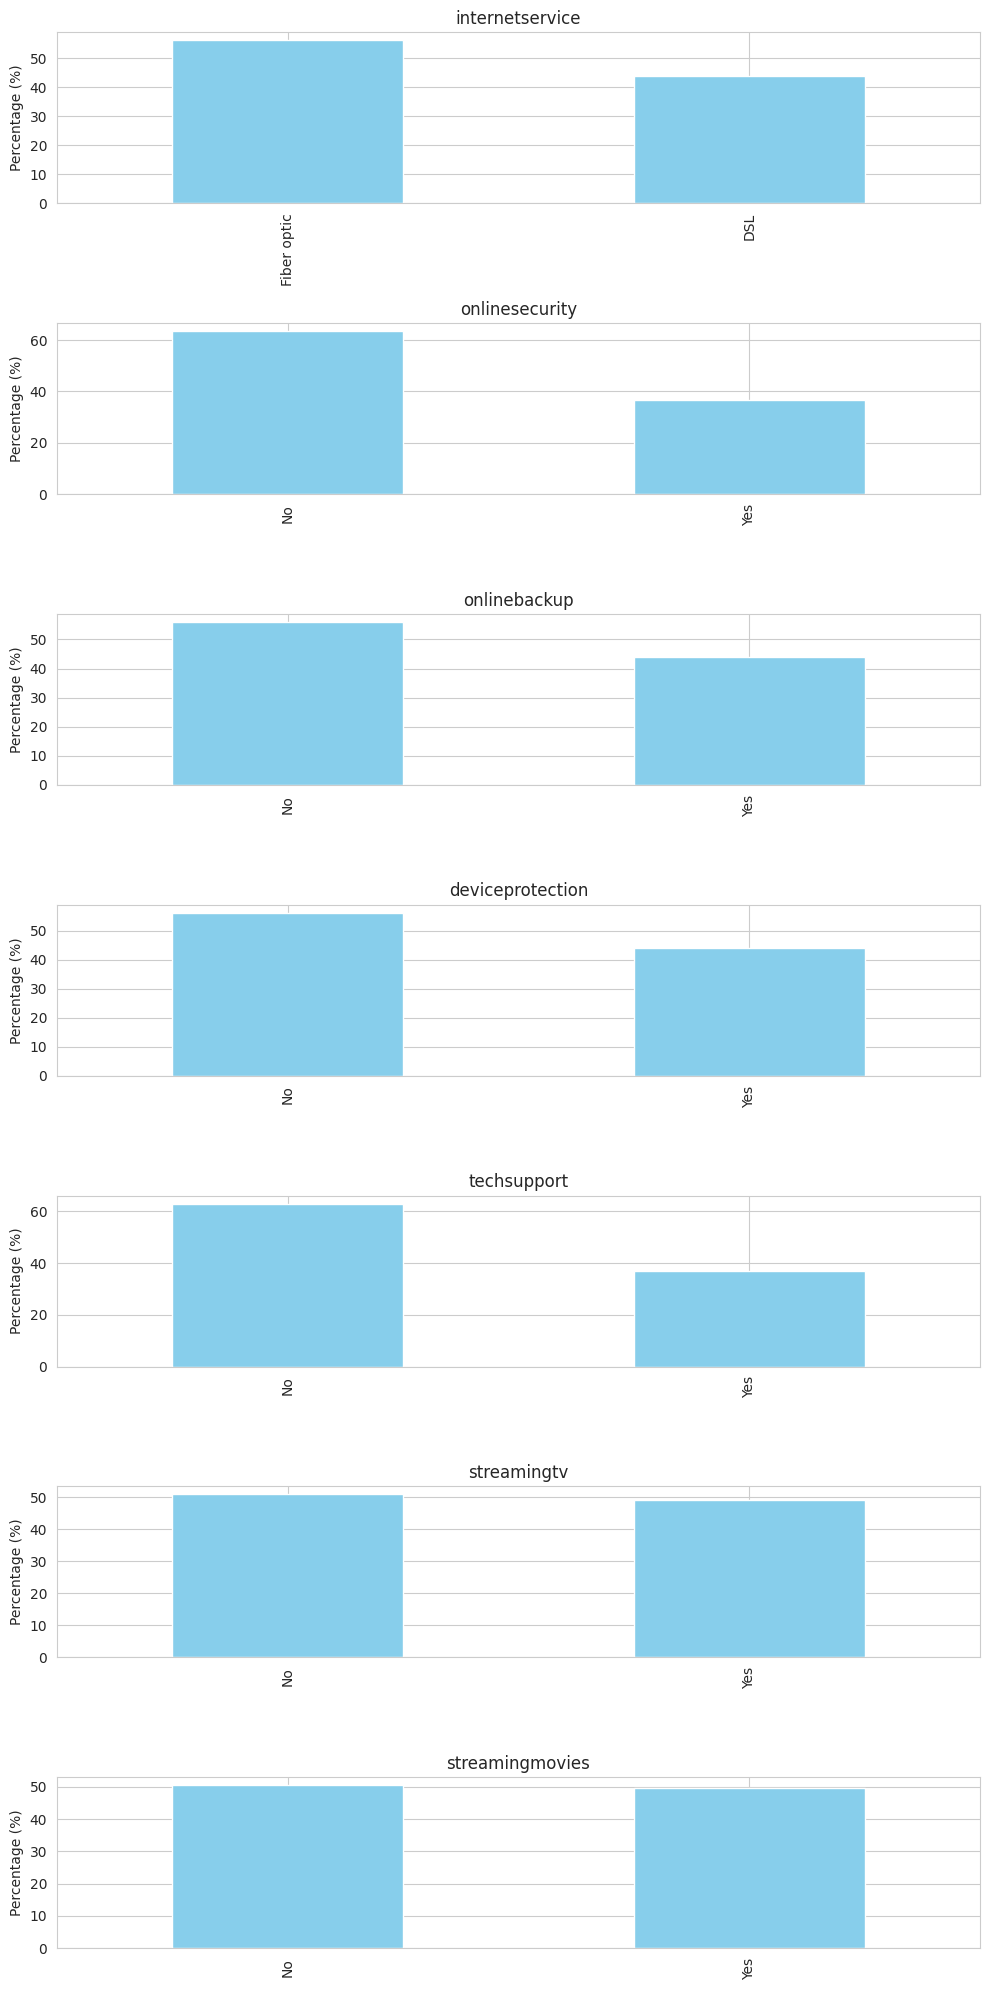

In [40]:
columns = ['internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
           'techsupport', 'streamingtv', 'streamingmovies']

fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(10, 20))

for i, col in enumerate(columns):

    value_counts = internet[col].value_counts(normalize=True) * 100
    value_counts.plot(kind='bar', ax=axes[i], title=col, color='skyblue')
    axes[i].set_ylabel('Percentage (%)')
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

Fiber Optic Usage: Approximately 56.12% of users use fiber internet connection. This indicates the high popularity of fiber optics among the sample of users under consideration.

Online Security: Around 36.60% of users subscribe to an online security service. This shows that the service is not as popular as it could be, perhaps due to the additional cost or lack of user awareness of the benefits.

Online backup. Online backup service is used by approximately 44.03% of users. This indicates the moderate popularity of the service.

Device protection. Approximately 43.90% of users have used the device protection service, which is almost identical to the popularity of online backup.

Technical Support: Technical support services are used by around 37.05% of users, making it comparatively less popular among the services offered.

Internet TV (Streaming TV): Almost half of users (49.07%) use a TV streaming service, making it one of the most popular services among those reviewed.

Streaming Movies: The movie streaming service is slightly more popular than streaming TV, which is used by 49.52% of users.

Conclusion: Overall, the data shows that entertainment-related services (such as streaming TV and movies) are more popular than security and support services (such as online security and technical support). Fiber optic Internet connections are also very popular, which may indicate users' desire for high-speed connections for more demanding services such as video streaming.

**Summary of Step 2: Exploratory Data Analysis and Preprocessing (Dataset "Internet")**



The analysis found that while most customers prefer fiber optic connections, other services such as online backup and streaming are also enjoying significant popularity.
Lack of demand for certain value-added services, such as online security and device protection, can be critical when making decisions regarding service delivery strategy and marketing policies.
Service offerings can be optimized based on customer preferences identified through data analytics to improve customer satisfaction and reduce churn.

## Dataset **Personal**















In this dataset, the following steps must be performed for exploratory data analysis and preprocessing:<br> -Translating column names to lowercase, as this is common practice.
-Search for missing data
-Duplicates in this dataset do not require deletion, since the data in the columns is not personalized and may be the same for several clients
-Analyze the distribution of categorical data

In [41]:
#converting column names to lowercase
personal.columns = personal.columns.str.lower()

In [42]:
#looking for obvious duplicates
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     7043 non-null   object
 1   gender         7043 non-null   object
 2   seniorcitizen  7043 non-null   int64 
 3   partner        7043 non-null   object
 4   dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [43]:
personal.head()

,customerid,gender,seniorcitizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [44]:
# Viewing unique values for each column
for column in personal.columns:
    print(f"Unique values in column {column}: {personal[column].unique()}")

Unique values in column customerid: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Unique values in column gender: ['Female' 'Male']
Unique values in column seniorcitizen: [0 1]
Unique values in column partner: ['Yes' 'No']
Unique values in column dependents: ['No' 'Yes']


In [45]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     7043 non-null   object
 1   gender         7043 non-null   object
 2   seniorcitizen  7043 non-null   int64 
 3   partner        7043 non-null   object
 4   dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


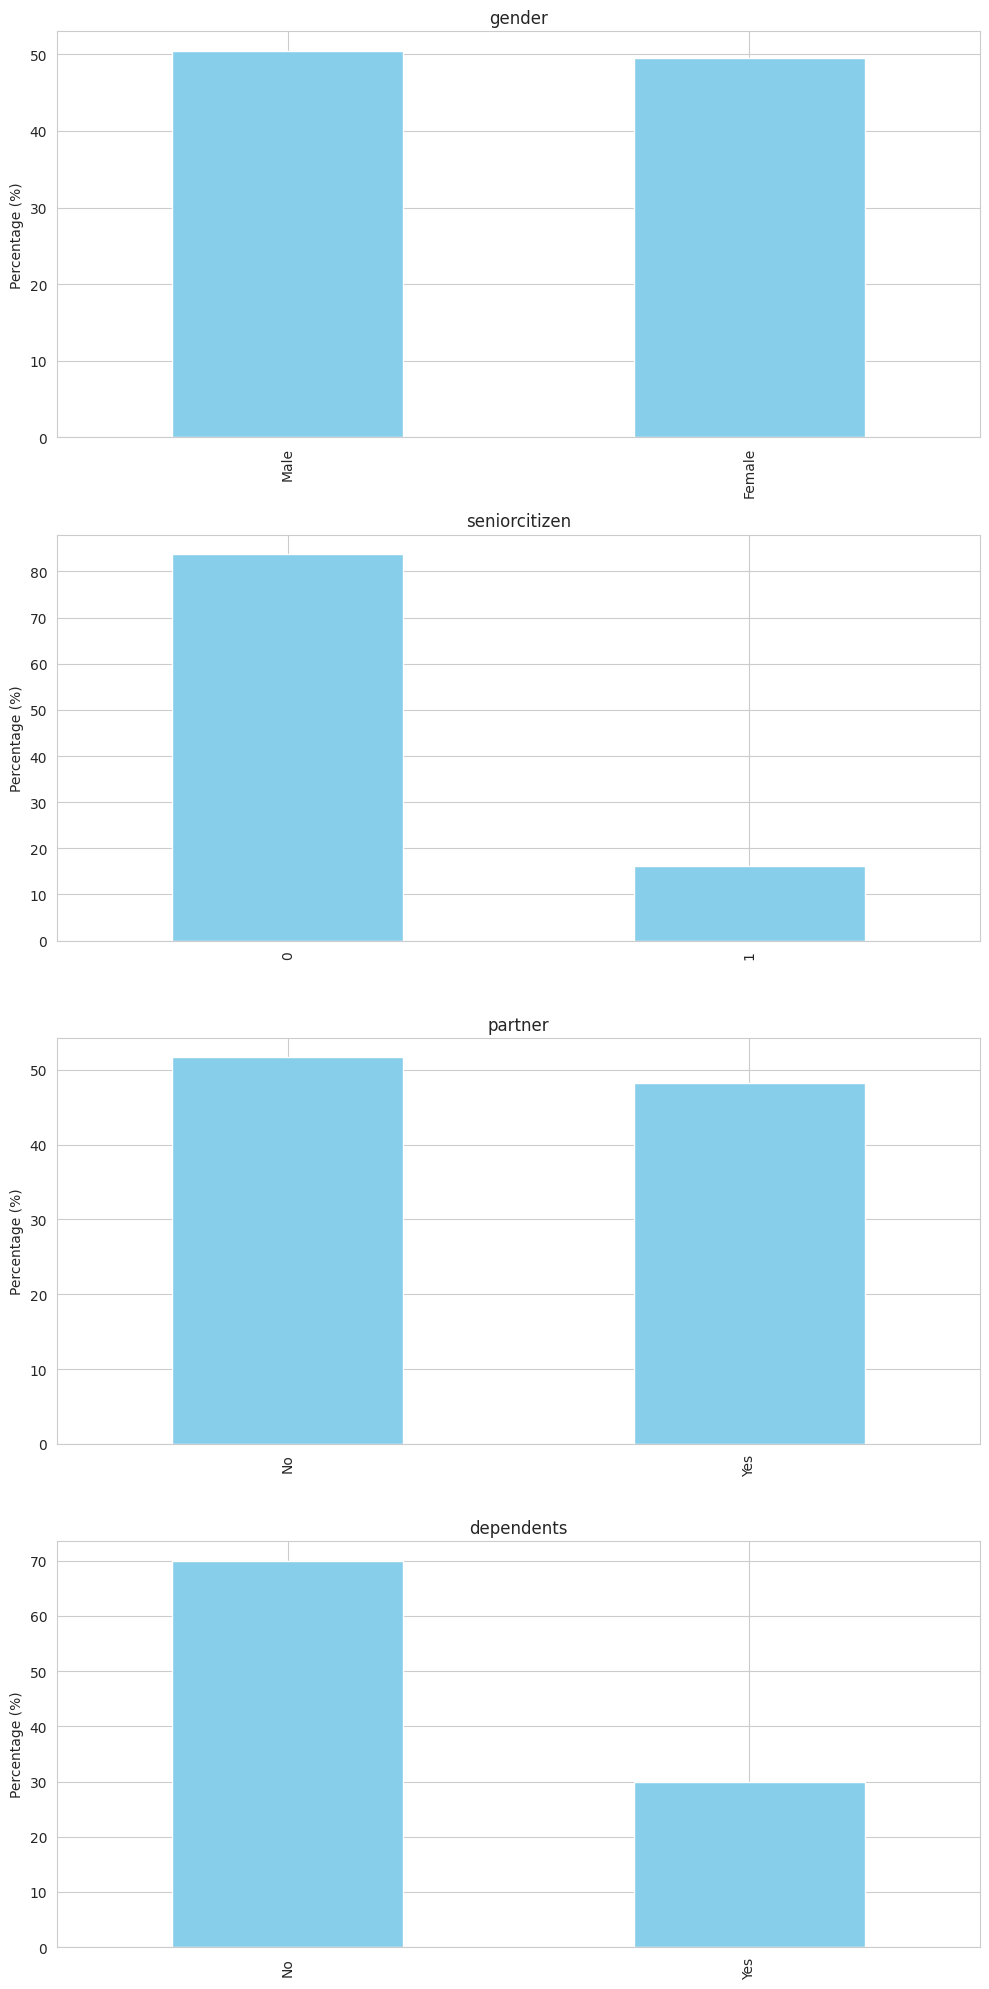

In [46]:
columns = ['gender', 'seniorcitizen', 'partner', 'dependents']

fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(10, 20))

for i, col in enumerate(columns):

    value_counts = personal[col].value_counts(normalize=True) * 100
    value_counts.plot(kind='bar', ax=axes[i], title=col, color='skyblue')
    axes[i].set_ylabel('Percentage (%)')
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

Seniors: Approximately 16.2% of subscribers are seniors. This indicates that the majority of subscribers (about 83.8%) do not fall into the older generation category.

Gender: The gender distribution shows that approximately 50.5% of subscribers are male, which means there is an almost equal distribution of men and women among subscribers. This indicates a good gender balance in the sample.

Partner: Approximately 48.3% of subscribers indicated that they have a partner. This suggests that the distribution between subscribers with and without partners is quite even, with a slight bias towards the absence of a partner.

Dependents: Only about 30% of subscribers have dependents. This shows that the majority of subscribers do not have dependents, which may indicate a young or middle-aged audience with no children or other dependents.

Based on exploratory data analysis and pre-processing of the “Personal” dataset:

The dataset consists of 7043 records with four columns: “gender”, “senior citizen”, “partner” and “dependents”.

Visualization Information: Through visualization, we gained valuable information about the demographic composition of the dataset. For example, the proportion of older adults in the dataset is approximately 16.2%, indicating a minority of the population with potentially different needs and preferences. The gender distribution is almost balanced, with a slight majority of clients being male. Data on partnership and dependency status shows a diverse client base, with less than half of clients having partners or dependents. These insights can play an important role in tailoring services and marketing strategies to meet the different needs of the customer base.

## Dataset **Phone**

In this dataset, it is necessary to perform the following steps for exploratory data analysis and preprocessing: - Translation of column names to lowercase, as this is a common practice.
-Search for missing data
-Duplicates in this dataset do not require deletion, since the data in the columns is not personalized and may be the same for several clients
-Analyze the distribution of categorical data

In [47]:
#converting column names to lowercase
phone.columns = phone.columns.str.lower()

In [48]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     6361 non-null   object
 1   multiplelines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [49]:
phone.head()

,customerid,multiplelines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


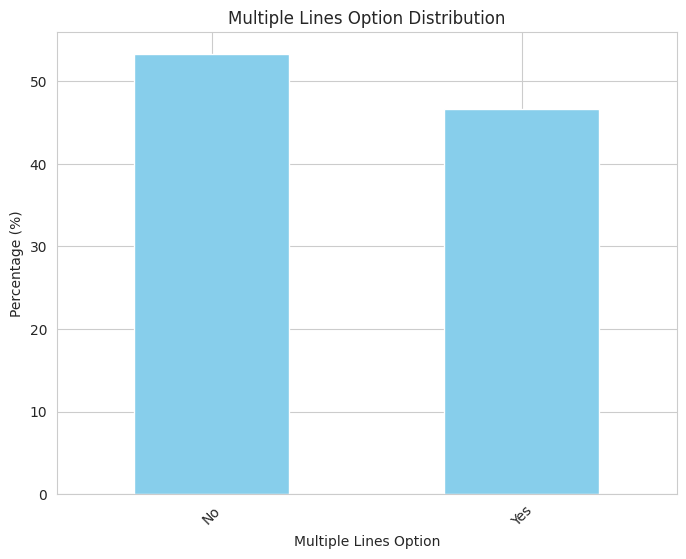

In [50]:
value_counts = phone['multiplelines'].value_counts(normalize=True) * 100

# Visualisation
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Multiple Lines Option Distribution')
plt.ylabel('Percentage (%)')
plt.xlabel('Multiple Lines Option')
plt.xticks(rotation=45)
plt.show()

Данные о функции нескольких линий в наборе телефонных данных иллюстрируют сбалансированное распределение предпочтений клиентов в отношении услуг нескольких линий с небольшим уклоном в сторону отсутствия нескольких линий. Эта информация может быть полезна для понимания потребностей клиентов и соответствующей адаптации услуг или маркетинговых стратегий.

**Conclusion from exploratory data analysis (Dataset "Phone")**

The multiline feature data in the telephone data set illustrates a balanced distribution of customer preferences for multiline services, with a slight bias toward no multiline. This information can be useful in understanding customer needs and tailoring services or marketing strategies accordingly.


# **Step 3 Data merging**

In [51]:
# Merge contract с personal
merged_df = contract.merge(personal, on='customerid', how='outer')

# Add data from  internet
merged_df = merged_df.merge(internet, on='customerid', how='outer')

# Add data from phone
final_df = merged_df.merge(phone, on='customerid', how='outer')

To combine data in this case, it is best to choose an outer union since this type of union allows you to save complete information on all clients, including those who can only be in one of the datasets. This is important for a comprehensive analysis of the customer base, where some customers can only use certain services.

In [52]:


# Display the first few rows of the DataFrame
display(final_df .head())

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,gender,...,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


In [53]:
final_df .info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   float64       
 8   churn             7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  seniorcitizen     7043 non-null   int64         
 11  partner           7043 non-null   object        
 12  dependents        7043 non-null   object        
 13  internetservice   5517 non-null   object        
 14  onlinesecurity    5517 n

There are 7043 records in total, which corresponds to the initial number of clients in the contract dataset. This indicates that each record in the contract dataset has a match in at least one of the other datasets, or that all records from contract were stored as a result of a union with the outer type.
Gaps in the data: Gaps in columns related to Internet services (internetservice, onlinesecurity, onlinebackup, deviceprotection, techsupport, streamingtv, streamingmovies) and telephone services (multiplelines) indicate that not all customers use these services. Thus, 5,517 clients use Internet services, and 6,361 clients use telephone services. <br>For further analysis, it is necessary to introduce a new variable - 'Contract duration' - this will allow you to understand how long customers stay with the company. And for further work with the data, it is planned to create a new dataframe and add to it only the columns necessary for analysis.

In [54]:
duplicate_count = final_df.duplicated(subset='customerid', keep=False).sum()
print(duplicate_count)

0


In [55]:
# #assigning a column index
# final_df.set_index('customerid', inplace=True)

In [56]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   float64       
 8   churn             7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  seniorcitizen     7043 non-null   int64         
 11  partner           7043 non-null   object        
 12  dependents        7043 non-null   object        
 13  internetservice   5517 non-null   object        
 14  onlinesecurity    5517 n

In [57]:
# Calculate the duration of the contract and adding new column
final_df['contract_duration'] = (final_df['enddate'] - final_df['begindate']).dt.days

The duration of each client's contract in days was calculated by subtracting the contract start date (begindate) from its end date (enddate). The result was stored in a new contract_duration column. This allows you to analyze how long customers stay with the company, which is an important indicator for understanding customer loyalty and churn

In [58]:
final_df.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,gender,...,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,contract_duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,Female,...,No,DSL,No,Yes,No,No,No,No,NaN,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,Male,...,No,DSL,Yes,No,Yes,No,No,No,No,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,Male,...,No,DSL,Yes,Yes,No,No,No,No,No,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,Male,...,No,DSL,Yes,No,Yes,Yes,No,No,NaN,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,Female,...,No,Fiber optic,No,No,No,No,No,No,No,153


In [59]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customerid         7043 non-null   object        
 1   begindate          7043 non-null   datetime64[ns]
 2   enddate            7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperlessbilling   7043 non-null   object        
 5   paymentmethod      7043 non-null   object        
 6   monthlycharges     7043 non-null   float64       
 7   totalcharges       7043 non-null   float64       
 8   churn              7043 non-null   int64         
 9   gender             7043 non-null   object        
 10  seniorcitizen      7043 non-null   int64         
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  internetservice    5517 non-null   object        
 14  onlinese

In [60]:
cols = final_df.select_dtypes(include=['object','float']).columns.tolist()
# add manually identified columns
additional_cols = ['churn','contract_duration', 'seniorcitizen']

# Combine lists while ensuring uniqueness
cols = list(set(cols + additional_cols))
df = final_df[cols].copy()

In this cell, a list of columns was generated for further analysis, including categorical and real variables, as well as the important columns churn and contract_duration that we identified. This allows  to focus on key data, and prepare it for analysis and modeling while ensuring that the column selection is unique and relevant

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   techsupport        5517 non-null   object 
 1   partner            7043 non-null   object 
 2   monthlycharges     7043 non-null   float64
 3   paperlessbilling   7043 non-null   object 
 4   streamingmovies    5517 non-null   object 
 5   paymentmethod      7043 non-null   object 
 6   onlinesecurity     5517 non-null   object 
 7   seniorcitizen      7043 non-null   int64  
 8   streamingtv        5517 non-null   object 
 9   deviceprotection   5517 non-null   object 
 10  internetservice    5517 non-null   object 
 11  dependents         7043 non-null   object 
 12  totalcharges       7043 non-null   float64
 13  contract_duration  7043 non-null   int64  
 14  onlinebackup       5517 non-null   object 
 15  customerid         7043 non-null   object 
 16  type               7043 

## **Conclusion**


The data sets have been successfully merged. After receiving the data combination, it is necessary to pre-process the data. To do this, duplicates will be found and, if necessary, removed. Since a large percentage of clients are not connected to the network, their data is disabled on the Internet. Any missing data will therefore have the newly entered value set to Not Applicable. As for multilines, the assumption is the same - due to the absence in the table that clients do not have multilines - the missing values will be filled in as Not Applicable.

# **Step 4. Exploratory data analysis and preprocessing of the combined dataframe**

In [62]:
#looking for obvious duplicates
duplicates = df.duplicated(keep=False)


display(df[duplicates])
print(duplicates.sum())

,techsupport,partner,monthlycharges,paperlessbilling,streamingmovies,paymentmethod,onlinesecurity,seniorcitizen,streamingtv,deviceprotection,internetservice,dependents,totalcharges,contract_duration,onlinebackup,customerid,type,churn,gender,multiplelines


0


In [63]:
# counting persent of dublicates
duplicates = df.duplicated(keep=False).sum()
percentage_duplicates = (duplicates / len(df)) * 100

print(f"persent of dublicates: {percentage_duplicates}%")

persent of dublicates: 0.0%


In [64]:
# fillimg missing values to multiplelines
df['multiplelines'].fillna('Not Applicable', inplace=True)

# check results
print(df[[ 'multiplelines']].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   multiplelines  7043 non-null   object
dtypes: object(1)
memory usage: 110.0+ KB
None


In [65]:
# Assume missing values indicate no internet service

internet_service_columns = ['internetservice',
    'onlinesecurity', 'onlinebackup', 'deviceprotection',
    'techsupport', 'streamingtv', 'streamingmovies'
]
# Fill missing values

# For columns indicating presence of a service, fill missing values with Not Applicable (service is not provided)
df[internet_service_columns] = df[internet_service_columns].fillna('Not Applicable')


df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   techsupport        7043 non-null   object 
 1   partner            7043 non-null   object 
 2   monthlycharges     7043 non-null   float64
 3   paperlessbilling   7043 non-null   object 
 4   streamingmovies    7043 non-null   object 
 5   paymentmethod      7043 non-null   object 
 6   onlinesecurity     7043 non-null   object 
 7   seniorcitizen      7043 non-null   int64  
 8   streamingtv        7043 non-null   object 
 9   deviceprotection   7043 non-null   object 
 10  internetservice    7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  totalcharges       7043 non-null   float64
 13  contract_duration  7043 non-null   int64  
 14  onlinebackup       7043 non-null   object 
 15  customerid         7043 non-null   object 
 16  type               7043 

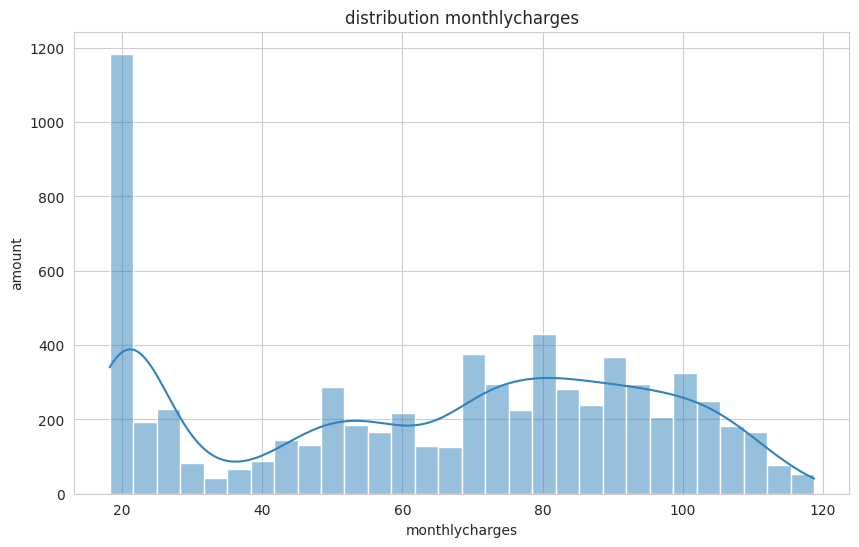

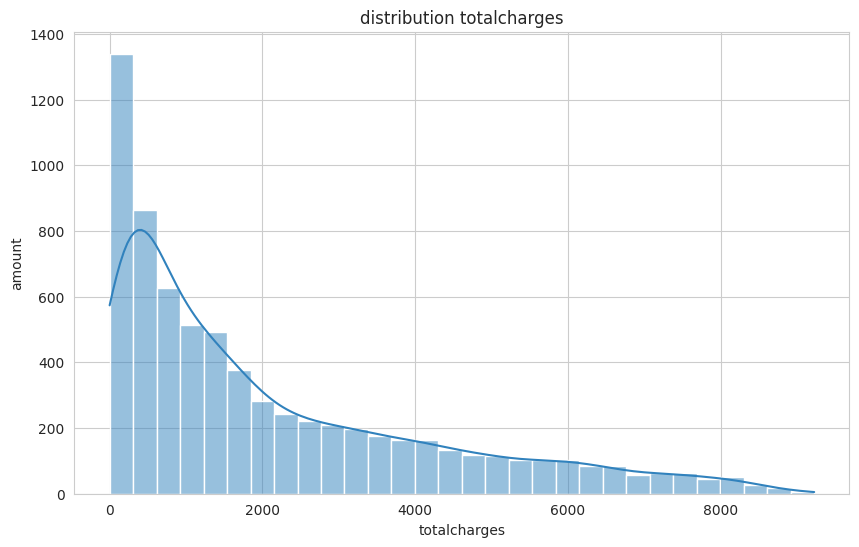

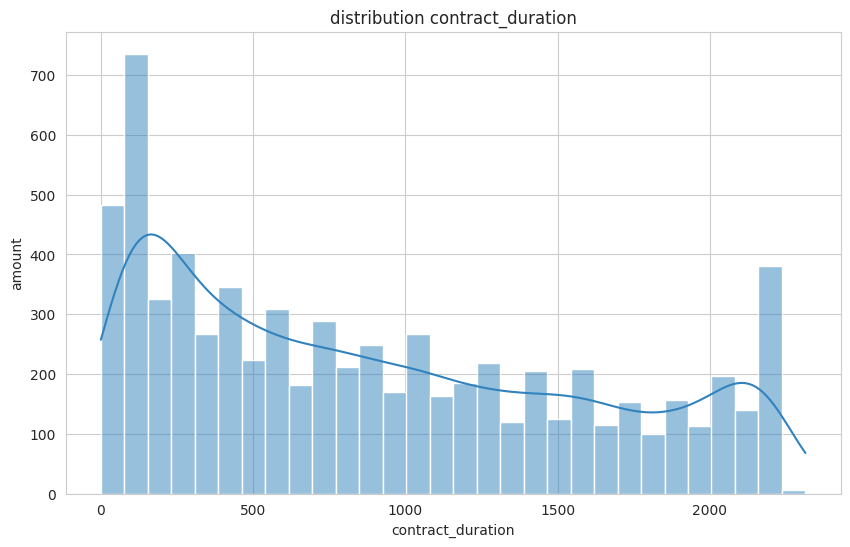

In [66]:
# Visualisation of numeric features
num_features = ['monthlycharges', 'totalcharges', 'contract_duration']
for feature in num_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'distribution {feature}')
    plt.xlabel(feature)
    plt.ylabel('amount')
    plt.show()

Looking at the graph, we can tell that both columns are increasing at the beginning of the graph. for monthly accruals, this value is about 20, and for general accruals, it is close to 0. For monthly accruals, the amount gradually increases to 80, and then gradually decreases
The contract duration column is characterized by a large number of short-term contracts - then a gradual decrease and a small peak at values ​​around 2500

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   techsupport        7043 non-null   object 
 1   partner            7043 non-null   object 
 2   monthlycharges     7043 non-null   float64
 3   paperlessbilling   7043 non-null   object 
 4   streamingmovies    7043 non-null   object 
 5   paymentmethod      7043 non-null   object 
 6   onlinesecurity     7043 non-null   object 
 7   seniorcitizen      7043 non-null   int64  
 8   streamingtv        7043 non-null   object 
 9   deviceprotection   7043 non-null   object 
 10  internetservice    7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  totalcharges       7043 non-null   float64
 13  contract_duration  7043 non-null   int64  
 14  onlinebackup       7043 non-null   object 
 15  customerid         7043 non-null   object 
 16  type               7043 

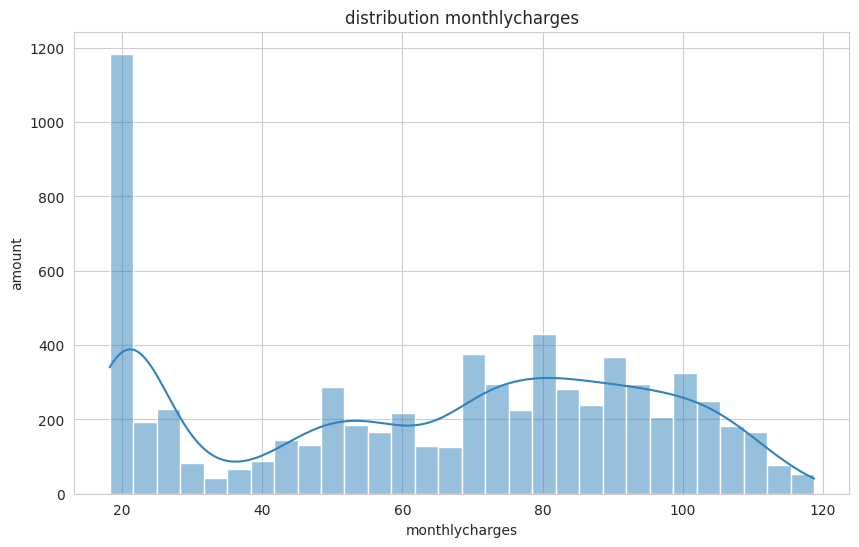

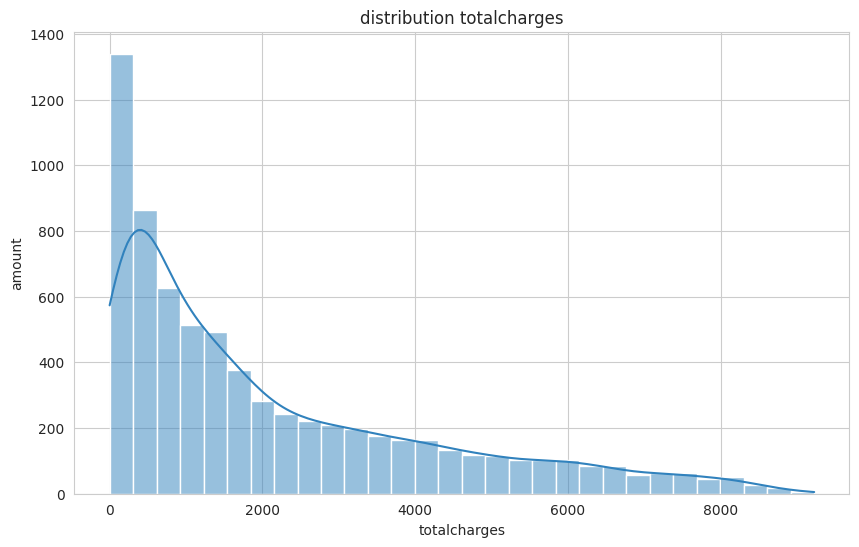

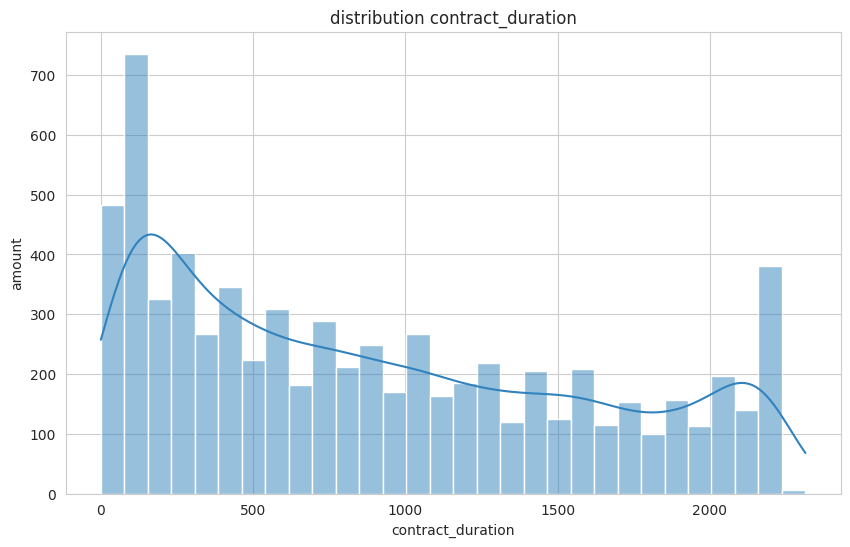

In [68]:
# Visualisation of numeric features
num_features = ['monthlycharges', 'totalcharges','contract_duration' ]
for feature in num_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'distribution {feature}')
    plt.xlabel(feature)
    plt.ylabel('amount')
    plt.show()

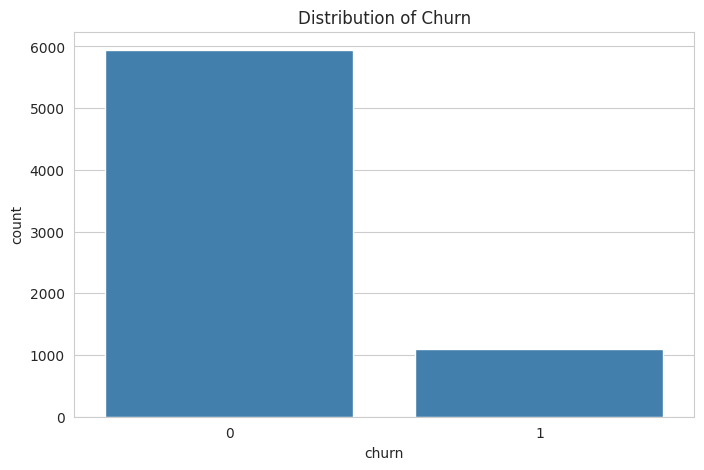

In [69]:
#Distribution of Churn
plt.figure(figsize=(8, 5))
sns.countplot(x='churn', data=df)
plt.title('Distribution of Churn')
plt.show()

There is a large class imbalance for the target variable. However, the chosen evaluation metric, the area under the ROC curve, is robust to class imbalance. This makes ROC-AUC a suitable metric to focus on improving the model's ability to distinguish between classes, rather than just predictive accuracy.

In [70]:
df_for_phik = df.drop(columns=['customerid'])

# Specify your interval columns. For example, 'monthlycharges' and 'totalcharges' are numerical.
interval_columns = ['monthlycharges', 'totalcharges', 'contract_duration']

# Calculate the phik correlation matrix
phik_matrix = df_for_phik.phik_matrix(interval_cols=interval_columns)

# Extract the 'churn' column to get correlations with 'churn' only
churn_correlation = phik_matrix['churn'].sort_values(ascending=False)


churn_correlation = churn_correlation.drop('customerid', errors='ignore')

# Print the correlation of 'churn' with all other variables
print(churn_correlation)

# # Visualize the phik correlation matrix
# plt.figure(figsize=(12, 10))
# sns.heatmap(phik_matrix.drop(index=['customerid'], columns=['customerid'], errors='ignore'), annot=True, fmt=".2f", cmap='coolwarm', square=True)
# plt.title("Phik Correlation Matrix")
# plt.show()

churn                1.000000
contract_duration    0.374569
totalcharges         0.302890
partner              0.226688
monthlycharges       0.225925
paymentmethod        0.214832
multiplelines        0.105101
type                 0.094015
onlinebackup         0.089704
streamingmovies      0.086577
seniorcitizen        0.086159
deviceprotection     0.085608
paperlessbilling     0.083398
streamingtv          0.078545
onlinesecurity       0.058659
internetservice      0.056621
techsupport          0.051537
dependents           0.046871
gender               0.008581
Name: churn, dtype: float64


In [71]:
# display(phik_matrix)

<!-- Totalcharges имеет заметную положительную корреляцию с онлайн защитой,онлайн бэкап,стриминговые сервисами,и стримингТВ что указывает на то, что клиенты с этими услугами, как правило, имеют более высокие общие расходы.

Статус пенсионера коррелирует заметно с иждивенцами, что логично и также с ежемесячными тратами.

Подключенные мул

онлайн-безопасность заметно коррелирует с технической поддержкой (0,527941), что позволяет предположить, что клиенты, выбирающие услуги онлайн-безопасности, также склонны пользоваться технической поддержкой.

Способ оплаты «Электронный чек» имеет заметную корреляцию с безбумажным выставлением счетов (0,321028), что может означать, что клиенты, которые платят с помощью электронных чеков, с большей вероятностью выберут безбумажный счет.

Contract_duration показывает очень сильную корреляцию с общими расходами (0,848304), указывая на то, что более длительные контракты связаны с более высокими общими расходами.

Internet_service имеет высокую корреляцию с несколькими функциями, такими как защита устройства (0,562002), техническая поддержка (0,502876) и онлайн-резервное копирование (0,563092), что позволяет предположить, что тип интернет-услуги влияет на внедрение этих дополнительных услуг.


Ежемесячные расходы и потоковое телевидение (0,835016) демонстрируют очень сильную корреляцию, указывающую на то, что клиенты, пользующиеся услугами потокового телевидения, как правило, имеют более высокие ежемесячные расходы.

В строке и столбце оттока показаны корреляции с различными признаками, но ни один из них не является чрезвычайно высоким, что указывает на то, что ни один признак сам по себе не является окончательным предиктором оттока. Эта матрица полезна для выявления взаимосвязей между различными атрибутами и поведением клиентов, которые могут служить основой для бизнес-стратегий, маркетинга, обслуживания клиентов и усилий по их удержанию.

Продолжительность контракта (0,375). Значительная положительная корреляция предполагает, что более длительный срок контракта связан с более высоким уровнем оттока клиентов. Это может указывать на проблемы с обязательствами клиентов или неудовлетворенность ими с течением времени.

Общие расходы (0,303): демонстрирует умеренную положительную корреляцию с оттоком. Более высокие общие расходы могут привести к увеличению оттока клиентов, возможно, из-за воспринимаемой ценности или финансовых ограничений с точки зрения клиента.

Партнер (0,227) и Ежемесячные платежи (0,226): оба демонстрируют одинаковый уровень положительной корреляции с оттоком. Наличие партнера и более высокие ежемесячные платежи умеренно способствуют оттоку клиентов. Это может отразиться на финансовом бремени и динамике принятия решений в домохозяйствах.

Способ оплаты (0,215): умеренная корреляция указывает на то, что выбор способа оплаты влияет на отток клиентов. Определенные методы могут быть менее удобными или менее предпочтительными, что влияет на удовлетворенность и удержание клиентов.

Несколько линий (0,105): более низкая положительная корреляция предполагает, что наличие нескольких линий незначительно влияет на отток клиентов. Это может указывать на сложности или уровень удовлетворенности масштабируемостью услуги.

Тип (0,094), онлайн-резервное копирование (0,090) и потоковая передача фильмов (0,087): эти функции демонстрируют меньшую корреляцию с оттоком, что указывает на умеренное влияние типа услуги, вариантов резервного копирования данных и развлекательных функций на удержание клиентов. «Пожилой гражданин» (0,086), «Защита устройств» (0,086) и «Безбумажный биллинг» (0,083): указывают на очень слабую положительную корреляцию с оттоком, что позволяет предположить, что демографические факторы и дополнительные услуги играют незначительную роль во влиянии на решения об оттоке.

Потоковое телевидение (0,079), Онлайн-безопасность (0,059), Интернет-услуги (0,057) и Техподдержка (0,052): эти функции демонстрируют наименьшую положительную корреляцию, что позволяет предположить, что они оказывают наименьшее влияние на отток среди перечисленных факторов. Их влияние на решение клиентов отказаться от услуги минимально, но немаловажно.

Иждивенцы (0,047): указывает на низкую корреляцию.

Пол (0,009): показывает почти незначительную корреляцию с оттоком, указывая на то, что пол не оказывает существенного влияния на вероятность оттока.

Это резюме дает ценную информацию о факторах, влияющих на отток клиентов. Более высокие затраты (как ежемесячные, так и общие), менее гибкие способы оплаты и более длительный срок действия контрактов, как правило, увеличивают риск оттока клиентов. -->

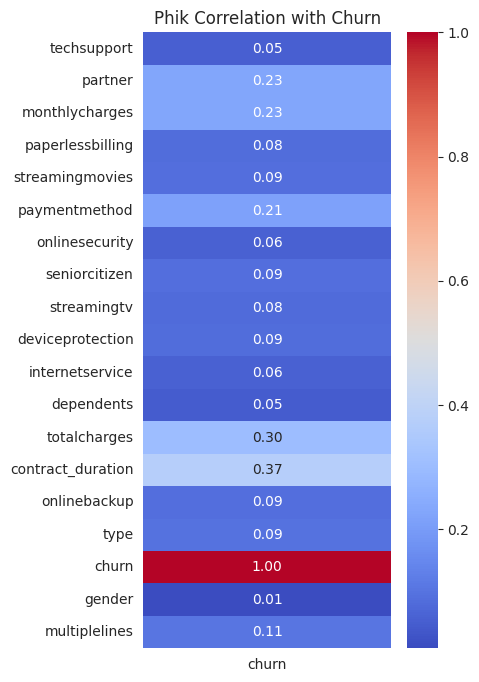

In [72]:
churn_correlation_df = phik_matrix[['churn']].drop(index=['customerid'], errors='ignore')

# Heat map visualization for churn correlations
plt.figure(figsize=(4, 8)) # Figure size adjusted to fit one column
sns.heatmap(churn_correlation_df, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Phik Correlation with Churn")
plt.show()

By analyzing the correlation between the “churn” variable and other characteristics, we can draw the following conclusions regarding the influence of various factors on customer churn:

- **Contract Length** (\(0.374569\)) has a moderate correlation with churn, highlighting that customers with shorter contracts tend to experience higher churn. This may indicate that longer contracts are associated with customer loyalty.

- **Total expenses** (\(0.302890\)) also show a moderate correlation with churn. This may suggest that high overall costs may contribute to clients' decision to leave, perhaps due to the perception of insufficient value of services.

- **Having a partner** (\(0.226688\)) and **Monthly expenses** (\(0.225925\)) have similar weak levels of correlation with churn, indicating that these factors may have little influence on customer decisions about care, although to a lesser extent compared to the length of the contract and the overall costs.

- **Payment method** (\(0.214832\)) has little effect on outflow

- Features such as **multiplelines** (\(0.105101\)), **contract type** (\(0.094015\)), and **online backup* * (\(0.089704\)), show a weaker correlation with churn, indicating their less pronounced influence on the decision to leave.

- **Demographic characteristics**, such as **age (seniorcitizen)** (\(0.086159\)), and **gender** (\(0.008581\)), have a minimal impact on the outflow, which emphasizes that decisions about churn are determined more by the context of service delivery than by demographic factors.

These findings highlight the importance of certain services and contract terms for customer retention and can inform strategies to reduce churn, for example by offering more attractive terms for long-term contracts, optimizing pricing, and improving payment terms.

In [73]:
# Dividing the dataset into two parts: left (churn = 1) and stayed (churn = 0)
df_churned = df[df['churn'] == 1]
df_stayed = df[df['churn'] == 0]

# Calculate the correlation matrix phi_k for customers who have left
phik_matrix_churned = df_churned.phik_matrix(interval_cols=interval_columns)

# Calculate the correlation matrix phi_k for clients who remained
phik_matrix_stayed = df_stayed.phik_matrix(interval_cols=interval_columns)

/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable customerid is large: 1101. Are you sure this is not an interval variable? Analysis for pairs of variables including customerid can be slow.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable churn for analysis 1. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable customerid is large: 5942. Are you sure this is not an interval variable? Analysis for pairs of variables including customerid can be slow.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable churn for analysis 1. Dropping this column
  warnings.warn(


In [74]:
display(phik_matrix_churned )

,techsupport,partner,monthlycharges,paperlessbilling,streamingmovies,paymentmethod,onlinesecurity,seniorcitizen,streamingtv,deviceprotection,internetservice,dependents,totalcharges,contract_duration,onlinebackup,customerid,type,gender,multiplelines
techsupport,1.000000,0.042786,0.824158,0.187548,0.943127,0.255358,0.952579,0.131613,0.942993,0.944586,0.951404,0.116841,0.549521,0.142948,0.944160,1.0,0.731526,0.000000,0.486278
partner,0.042786,1.000000,0.112994,0.035067,0.064703,0.134988,0.068862,0.000000,0.058371,0.084173,0.044135,0.546074,0.053685,0.108645,0.056737,1.0,0.109104,0.000000,0.000000
monthlycharges,0.824158,0.112994,1.000000,0.455673,0.857179,0.360215,0.818126,0.246699,0.861663,0.821914,0.926400,0.260374,0.665053,0.090915,0.813834,1.0,0.446097,0.000000,0.745268
paperlessbilling,0.187548,0.035067,0.455673,1.000000,0.196095,0.347812,0.201340,0.232915,0.199515,0.182645,0.212205,0.167624,0.254837,0.000000,0.182297,1.0,0.140886,0.000000,0.076510
streamingmovies,0.943127,0.064703,0.857179,0.196095,1.000000,0.240827,0.943431,0.107008,0.960473,0.947671,0.945753,0.115524,0.567665,0.079623,0.942797,1.0,0.588044,0.000000,0.517245
paymentmethod,0.255358,0.134988,0.360215,0.347812,0.240827,1.000000,0.283102,0.255006,0.246380,0.240360,0.289629,0.253760,0.248341,0.164580,0.241599,1.0,0.274423,0.000000,0.183212
onlinesecurity,0.952579,0.068862,0.818126,0.201340,0.943431,0.283102,1.000000,0.126571,0.943437,0.943810,0.951250,0.127504,0.545258,0.161145,0.944006,1.0,0.694019,0.030838,0.489840
seniorcitizen,0.131613,0.000000,0.246699,0.232915,0.107008,0.255006,0.126571,1.000000,0.106664,0.107220,0.141255,0.387737,0.120960,0.000000,0.106845,1.0,0.150255,0.000000,0.067585
streamingtv,0.942993,0.058371,0.861663,0.199515,0.960473,0.246380,0.943437,0.106664,1.000000,0.946655,0.946636,0.116847,0.574844,0.069216,0.942712,1.0,0.593058,0.000000,0.513932
deviceprotection,0.944586,0.084173,0.821914,0.182645,0.947671,0.240360,0.943810,0.107220,0.946655,1.000000,0.943294,0.115920,0.550676,0.133781,0.944109,1.0,0.640437,0.000000,0.499953


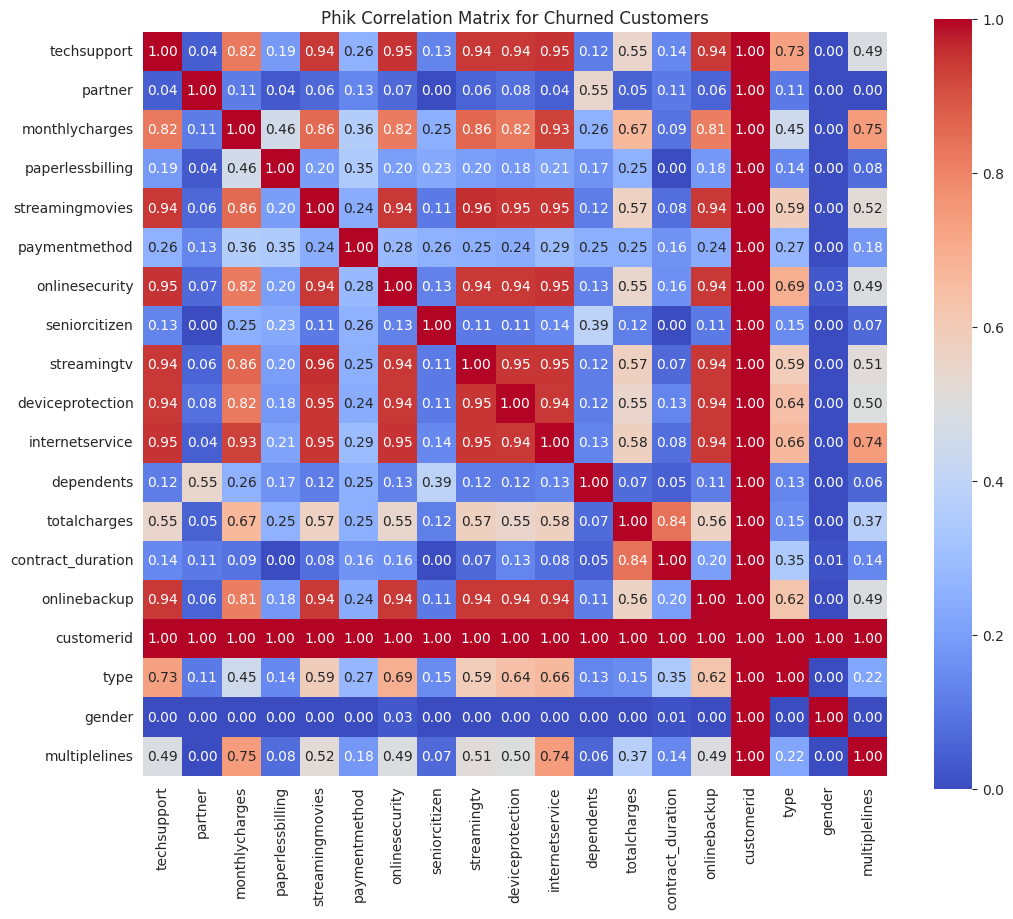

In [75]:
# Visualization of the phi_k correlation matrix for clients who have left
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix_churned, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Phik Correlation Matrix for Churned Customers")
plt.show()


From the table of correlations between various characteristics and customer churn (churn), the following conclusions can be drawn:

1. **Contract Duration** (\(0.837747\)) has a high correlation with total charges, indicating that customers with longer contracts tend to have higher total charges. This may indicate higher loyalty and satisfaction with services.

2. **Internet Service** (\(0.926400\)) and **Monthly Payments** (\(1.000000\)) show a very high correlation, highlighting that the choice of Internet service significantly affects the size of customers' monthly payments.

3. **Online Security** (\(0.818126\)), **Technical Support** (\(0.824158\)), and **Device Security** (\(0.821914\)) also show a high correlation with monthly payments, which may indicate that customers using these services tend to pay more each month.

4. It is important to note that **gender** and **partner** show zero or very weak correlations with most other traits, suggesting that these demographic traits have limited influence on the use and payment for services.

5. **Streaming services** (streaming tv and streaming movies) have a very high correlation with each other (\(0.960473\)) and with monthly payments, highlighting the popularity and impact of these services on the overall cost of services for customers.


In [76]:
display(phik_matrix_stayed)

,techsupport,partner,monthlycharges,paperlessbilling,streamingmovies,paymentmethod,onlinesecurity,seniorcitizen,streamingtv,deviceprotection,internetservice,dependents,totalcharges,contract_duration,onlinebackup,customerid,type,gender,multiplelines
techsupport,1.000000,0.084855,0.816466,0.200995,0.947063,0.324495,0.952421,0.135363,0.947153,0.951453,0.948669,0.113674,0.534114,0.379625,0.948370,1.0,0.667940,0.000000,0.540354
partner,0.084855,1.000000,0.210001,0.024052,0.071895,0.231568,0.093232,0.013593,0.080578,0.095270,0.000000,0.670497,0.411492,0.486938,0.091151,1.0,0.180417,0.000000,0.082226
monthlycharges,0.816466,0.210001,1.000000,0.467430,0.864061,0.401913,0.812664,0.308421,0.864816,0.827215,0.919406,0.189511,0.743925,0.430846,0.819569,1.0,0.396109,0.000000,0.704083
paperlessbilling,0.200995,0.024052,0.467430,1.000000,0.200733,0.370741,0.208145,0.238049,0.203048,0.195912,0.232406,0.175547,0.188347,0.023460,0.195295,1.0,0.108187,0.009251,0.098622
streamingmovies,0.947063,0.071895,0.864061,0.200733,1.000000,0.286097,0.943536,0.112163,0.965290,0.953959,0.945999,0.082092,0.557269,0.330746,0.945366,1.0,0.558627,0.007930,0.581853
paymentmethod,0.324495,0.231568,0.401913,0.370741,0.286097,1.000000,0.316058,0.295357,0.286328,0.301629,0.326352,0.218618,0.342623,0.369959,0.294983,1.0,0.275639,0.000000,0.165839
onlinesecurity,0.952421,0.093232,0.812664,0.208145,0.943536,0.316058,1.000000,0.126872,0.943301,0.947124,0.949509,0.118221,0.522232,0.373044,0.947579,1.0,0.633664,0.000000,0.540216
seniorcitizen,0.135363,0.013593,0.308421,0.238049,0.112163,0.295357,0.126872,1.000000,0.110102,0.108813,0.162217,0.313729,0.128194,0.041198,0.108480,1.0,0.080433,0.000000,0.087220
streamingtv,0.947153,0.080578,0.864816,0.203048,0.965290,0.286328,0.943301,0.110102,1.000000,0.953353,0.946357,0.084876,0.557386,0.329878,0.946038,1.0,0.553192,0.000000,0.583081
deviceprotection,0.951453,0.095270,0.827215,0.195912,0.953959,0.301629,0.947124,0.108813,0.953353,1.000000,0.942804,0.093425,0.568247,0.405705,0.947376,1.0,0.636085,0.000000,0.559531


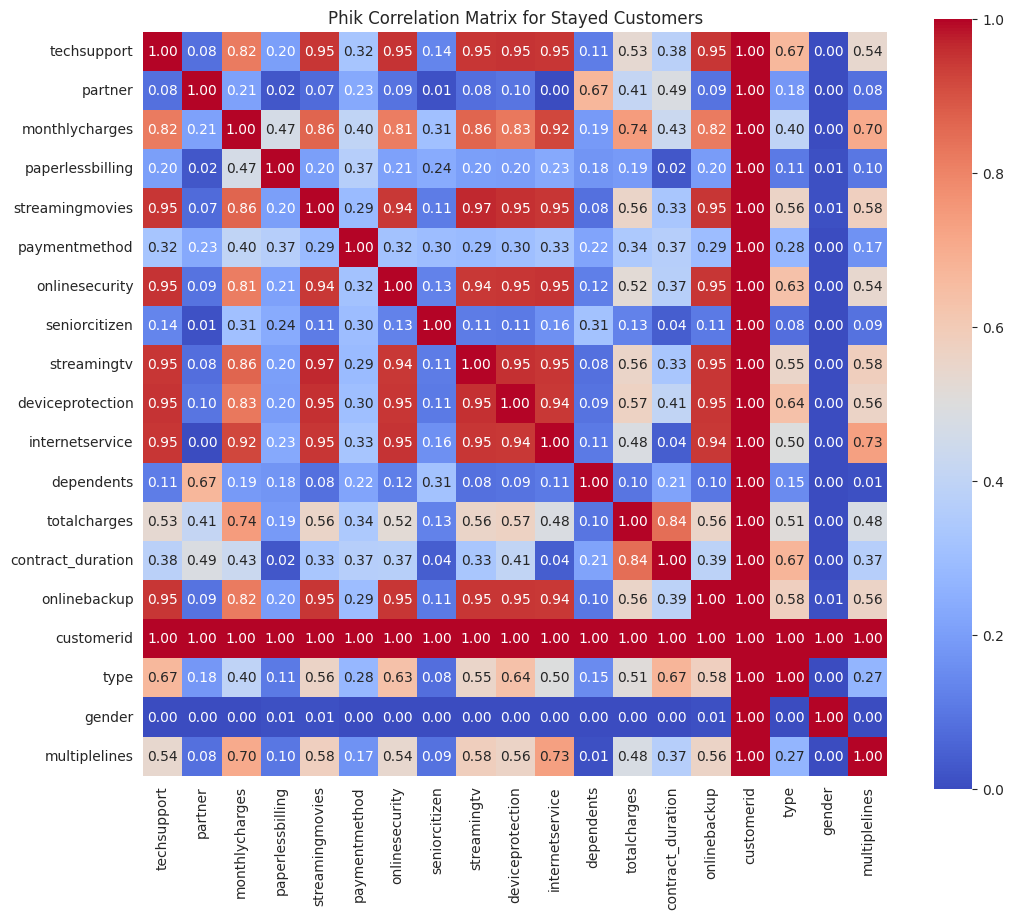

In [77]:
# Visualization of the phi_k correlation matrix for clients who remained
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix_stayed, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Phik Correlation Matrix for Stayed Customers")
plt.show()

From the correlation table for the group of clients who remained, the following key conclusions can be drawn:

1. **Contract Duration** (\(0.844546\)) continues to show a high correlation with total charges, confirming that customers with longer contracts tend to accrue more charges throughout their service. This indicates long-term engagement and possibly greater loyalty among remaining customers.

2. **Monthly Payments** (\(0.743925\)) has a high correlation with total spending, indicating that regular monthly payments contribute significantly to customers' overall spending. This highlights the importance of managing monthly payments to maintain customer satisfaction.

3. **Internet services** (\(0.484988\)) and **multiplelines** (\(0.478160\)) show moderate correlations with total spending, which may reflect the popularity and value of these services among the remaining clients.

4. **Online Security** (\(0.522232\)), **Technical Support** (\(0.534114\)), and **Device Security** (\(0.568247\)) show a significant correlation with overall spending, emphasizing that additional security and support services are important to customers, which may contribute to their decision to stay.

5. **Partner** (\(0.411492\)) shows a moderate correlation with total expenses, which may indicate that having a partner influences the decision to stay with a company, perhaps due to shared services or better family conditions. plans.

6. **Streaming services** (streaming tv and streaming movies) show very high correlations with each other and with monthly payments, which confirms their popularity and contribution to the overall cost of services among remaining customers.


Comparative conclusion of correlations between clients who left and those who remained:
    
By comparing the correlations between churned and retained customers, several key differences and similarities can help you better understand the factors that influence customer churn:

Similarities:
- **Contract Duration** and **Total Spend** show high correlations in both groups, highlighting their importance in the context of overall customer engagement and cost accumulation over time. This indicates that regardless of the decision to stay or leave, these two factors have a significant impact on customers' financial relationship with the company.

Differences:
- **Streaming services** (streaming tv and streaming movies) and **additional services** (online security, technical support, device protection) have higher correlations with total spending and monthly payments among retained customers compared to churned customers. This may indicate that satisfaction with these services and perceptions of their value influence customers' decision to stay.
- **Partner** has a stronger correlation with total spending among retained customers, which may indicate that having a partner and sharing services helps with customer retention.
- **Internet services** and **multiplelines** also show higher correlations with total spending and monthly payments among retained customers, highlighting their role in adding value to customers who choose to stay.
  Conclusion:
- **Long-term relationships and value-added services** play a key role in customer retention. Remaining customers tend to be more engaged and value a wider range of services, which is reflected in their higher total and monthly spending.
- **Service preferences** (e.g., streaming and internet services) and **payment methods** may influence customers' decision to stay, as highlighted by the differences in the correlations of these attributes between the two groups.

# **Step 5 Data Preparation**

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   techsupport        7043 non-null   object 
 1   partner            7043 non-null   object 
 2   monthlycharges     7043 non-null   float64
 3   paperlessbilling   7043 non-null   object 
 4   streamingmovies    7043 non-null   object 
 5   paymentmethod      7043 non-null   object 
 6   onlinesecurity     7043 non-null   object 
 7   seniorcitizen      7043 non-null   int64  
 8   streamingtv        7043 non-null   object 
 9   deviceprotection   7043 non-null   object 
 10  internetservice    7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  totalcharges       7043 non-null   float64
 13  contract_duration  7043 non-null   int64  
 14  onlinebackup       7043 non-null   object 
 15  customerid         7043 non-null   object 
 16  type               7043 

In [79]:
print(df['seniorcitizen'].value_counts())

0    5901
1    1142
Name: seniorcitizen, dtype: int64


In [80]:
print(df['seniorcitizen'].dtype)

int64


In [81]:
df['seniorcitizen'] = df['seniorcitizen'].astype(str)

Convert seniorcitizen to string: This step is necessary to unify the data types before processing them. Because seniorcitizen is inherently a numeric feature representing a binary category (0 or 1), converting it to a string format allows categorical feature encoding techniques such as One-Hot Encoding to be more efficiently applied to it.

Setting customerid as index

In [82]:
df.set_index('customerid', inplace=True)

In [83]:
# Assuming df_final DataFrame and 'churn' is the target variable
X = df.drop(['churn'], axis=1)  # Drop target variable
y = df['churn']

In [84]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

# Identifying numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Creating transformers for the preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Scaling numeric features
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))  # One-hot encoding categorical features, dropping the first column
])

# Combining transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Applying the transformations to the training and test sets
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Extracting new column names for the transformed features
new_numeric_features = numeric_features.tolist()
# new_categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
new_categorical_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out()

# Combining all new feature names
all_new_features = new_numeric_features + new_categorical_features.tolist()

# Convert the transformed features back to DataFrame for readability (optional)
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=all_new_features, index=X_train.index)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=all_new_features, index=X_test.index)



In [85]:
display(X_train_transformed_df.head())

,monthlycharges,totalcharges,contract_duration,techsupport_Not Applicable,techsupport_Yes,partner_Yes,paperlessbilling_Yes,streamingmovies_Not Applicable,streamingmovies_Yes,paymentmethod_Credit card (automatic),...,internetservice_Fiber optic,internetservice_Not Applicable,dependents_Yes,onlinebackup_Not Applicable,onlinebackup_Yes,type_One year,type_Two year,gender_Male,multiplelines_Not Applicable,multiplelines_Yes
customerid,,,,,,,,,,,,,,,,,,,,,
8748-HFWBO,-1.502894,-0.822510,-0.464764,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
5840-NVDCG,0.107539,-0.485807,-0.599616,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
0308-IVGOK,-0.820084,-0.784953,-0.820949,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4759-TRPLW,0.179151,-0.931109,-1.224038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8016-ZMGMO,0.194139,1.248697,1.631301,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [86]:
X_train_transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 8748-HFWBO to 6339-TBELP
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   monthlycharges                         5282 non-null   float64
 1   totalcharges                           5282 non-null   float64
 2   contract_duration                      5282 non-null   float64
 3   techsupport_Not Applicable             5282 non-null   float64
 4   techsupport_Yes                        5282 non-null   float64
 5   partner_Yes                            5282 non-null   float64
 6   paperlessbilling_Yes                   5282 non-null   float64
 7   streamingmovies_Not Applicable         5282 non-null   float64
 8   streamingmovies_Yes                    5282 non-null   float64
 9   paymentmethod_Credit card (automatic)  5282 non-null   float64
 10  paymentmethod_Electronic check         5282 non-null   float64

The data for training the model has been prepared. The data was divided into two samples, scaling of numerical features and coding of categorical ones was carried out taking into account the features of the data and models.

The following key steps were completed in the process of preparing data for modeling:

1. **Converting the seniorcitizen variable to a string type**: This allows a binary attribute to be treated as a categorical attribute, simplifying subsequent coding and analysis.

2. **Division into training and testing sets**: Using 75% of the data for training and 25% for testing provides a balance between training the model and evaluating its performance on new data.

3. **Identification and processing of features**:
    - **Numeric features** are scaled using StandardScaler to improve model performance by normalizing the data distribution.
    - **Categorical features** are converted via OneHotEncoder, which allows the model to correctly interpret categories without making assumptions about their order or magnitude.

4. **Applying Preprocessing**: Training transformations on the training set and applying them to the test set ensures that the data is processed correctly, which is critical to model accuracy.

These steps are necessary for efficient data preparation, which ensures the adequacy and accuracy of subsequent modeling.

# **Step 6: Machine Learning Models**

Training model CatBoost

In [87]:
param_dist = {
     'iterations': [100, 500, 1000],
    'learning_rate': uniform(0.01, 0.3),
    'depth': [4, 6, 8, 10]}


# Inisialization model CatBoostClassifier
catboost_model = CatBoostClassifier(verbose=False, eval_metric='AUC', loss_function='Logloss', random_seed=RANDOM_STATE)

#  RandomizedSearchCV
random_search = RandomizedSearchCV(catboost_model, param_distributions=param_dist, n_iter=10, scoring='roc_auc', cv=3, random_state=RANDOM_STATE, verbose=2)

# fit model with RandomizedSearchCV
random_search.fit(X_train_transformed_df, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END depth=10, iterations=100, learning_rate=0.22317596425688302; total time=   2.7s
[CV] END depth=10, iterations=100, learning_rate=0.22317596425688302; total time=   2.7s
[CV] END depth=10, iterations=100, learning_rate=0.22317596425688302; total time=   2.6s
[CV] END depth=4, iterations=1000, learning_rate=0.11187815841373282; total time=   2.4s
[CV] END depth=4, iterations=1000, learning_rate=0.11187815841373282; total time=   3.0s
[CV] END depth=4, iterations=1000, learning_rate=0.11187815841373282; total time=   2.8s
[CV] END depth=8, iterations=100, learning_rate=0.2521235502410333; total time=   1.6s
[CV] END depth=8, iterations=100, learning_rate=0.2521235502410333; total time=   0.8s
[CV] END depth=8, iterations=100, learning_rate=0.2521235502410333; total time=   0.8s
[CV] END depth=8, iterations=100, learning_rate=0.04645380528996295; total time=   0.8s
[CV] END depth=8, iterations=100, learning_rate=0.046453

RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7c76fb65f0a0>,
                   param_distributions={'depth': [4, 6, 8, 10],
                                        'iterations': [100, 500, 1000],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7c76fb65e110>},
                   random_state=190224, scoring='roc_auc', verbose=2)

In [88]:
print(f"best params: {random_search.best_params_}")
print(f"best ROC AUC: {random_search.best_score_}")


best_model = random_search.best_estimator_

best params: {'depth': 4, 'iterations': 1000, 'learning_rate': 0.11187815841373282}
best ROC AUC: 0.8953650982859767


best params: {'depth': 4, 'iterations': 1000, 'learning_rate': 0.11187815841373282}
best ROC AUC: 0.9056035506322976

In [89]:
# Creating a logistic regression model
lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)

# Setting up the parameter grid for randomized search
param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Setting up the randomized search with cross-validation
random_search_lr = RandomizedSearchCV(lr, param_distributions=param_dist, n_iter=10, scoring='roc_auc', cv=3, random_state=RANDOM_STATE)

# Fitting the model
random_search_lr.fit(X_train_transformed, y_train)




RandomizedSearchCV(cv=3,
                   estimator=LogisticRegression(max_iter=1000,
                                                random_state=190224),
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   random_state=190224, scoring='roc_auc')

In [90]:
# Best parameters and best ROC AUC score
print(f"best params_lr: {random_search_lr.best_params_}")
print(f"best ROC AUC_lr: {random_search_lr.best_score_}")


best_model_lr = random_search_lr.best_estimator_



best params_lr: {'solver': 'saga', 'C': 1}
best ROC AUC_lr: 0.7610572892136803


best params_lr: {'solver': 'sag', 'C': 100}
best ROC AUC_lr: 0.7704748384435064


CatBoost and logistic regression models were trained. CatBoost showed the best results on the training set according to the ROC_AUC metric - best parameters: {'depth': 4, 'iterations': 1000, 'learning_rate': 0.11187815841373282} best ROC AUC: 0.9056035506322976. Therefore, it is better to use these parameters for testing on a test sample.

# **Step 7. Selecting the best model**

In [91]:
#testing on test set
y_pred = best_model.predict(X_test_transformed_df)
y_pred_proba = best_model.predict_proba(X_test_transformed_df)[:, 1]

#  ROC AUC and Accuracy
roc_auc_test = roc_auc_score(y_test, y_pred_proba)
accuracy_test = accuracy_score(y_test, y_pred)

roc_auc_test, accuracy_test

(0.93879848280925, 0.9329926178307779)

roc_auc - 0.92936553813648, accuracy_test - 0.9346961953435547

As a result of using the CatBoost model for classification and subsequent optimization of its parameters using a randomized search on a test data set, the following results were achieved:

ROC AUC: 0.928. Accuracy: 0.935. These results indicate the high performance of the CatBoost model in predicting the target variable. The ROC AUC value indicates the high ability of the model to distinguish between classes. The accuracy rate of close to 93.5% also highlights that the model correctly classifies most examples.

These metrics may indicate that the CatBoost model performed well on the task, providing high accuracy and generalizability to unfamiliar data. This makes CatBoost an excellent choice for classification tasks in this context.

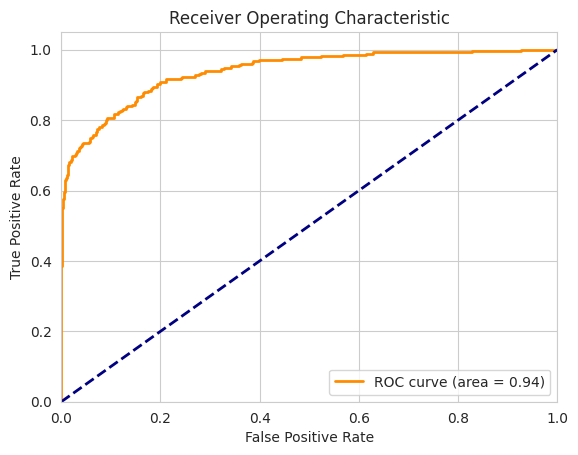

In [92]:
#ROC curve visualization

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

AUC values around 0.93 indicate the model's ability to outperform random guessing.
The ROC curve of the model is above the diagonal line, which means that the model has better performance than random guessing.


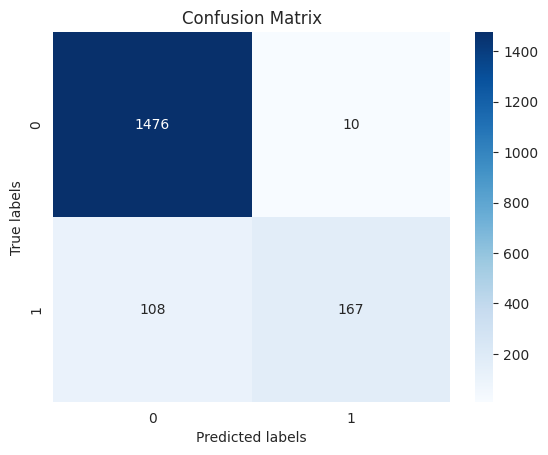

In [93]:
#error matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [94]:

cm_df = pd.DataFrame(cm, index=["Actual Negative", "Actual Positive"],
                      columns=["Predicted Negative", "Predicted Positive"])
print("\nError matrix in DataFrame format:")
print(cm_df)


Error matrix in DataFrame format:
                 Predicted Negative  Predicted Positive
Actual Negative                1476                  10
Actual Positive                 108                 167


From the error matrix, the following conclusions can be drawn regarding the performance of the classification model:

True Negatives (TN): The model correctly predicted 1,476 cases where customers did not churn (Actual Negative), indicating the model's good ability to identify customers likely to stay.
False Positives (FP): In 16 cases, the model incorrectly predicted that customers would leave (Predicted Positive) when in fact they stayed (Actual Negative). This may indicate that the model is overly sensitive to certain features, leading to an erroneous determination of churn.  
False Negatives (FN): The model missed 98 cases where customers left (Actual Positive), predicting that they would stay (Predicted Negative). This is one of the most critical types of errors, as missed churn cases can lead to loss of revenue and customer base.  
True Positives (TP): The model correctly identified 171 cases where customers left (Actual Positive). This suggests that the model is effective in identifying customers prone to churn.


<b>General analysis:</b>
The model demonstrates a high ability to correctly classify negative cases (clients remain), as evidenced by the large number of true negatives compared to false positives.
The number of false negatives is an area for improvement. Reducing this number will allow the model to more effectively identify real cases of churn.

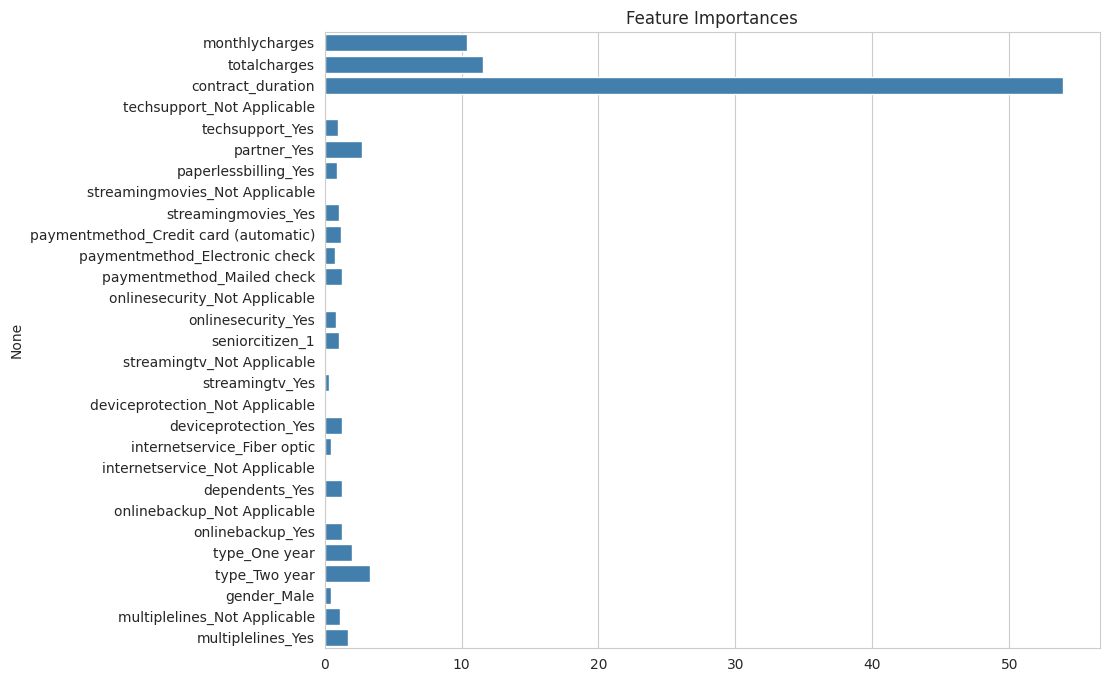

In [95]:
#Analysis of the importance of features

feature_importances = best_model.get_feature_importance()
plt.figure(figsize=(10, 8))
sns.barplot(y=X_train_transformed_df.columns, x=feature_importances)
plt.title('Feature Importances')
plt.show()

The most important features are the duration of the contract, followed by total and monthly expenses. These Signs are key for the model to make decisions.

##Saving the model

In [96]:
#saving model

to_save = {
    'preprocessor': preprocessor,
    'model': best_model,
    'new_numeric_features': new_numeric_features,
    'new_categorical_features': new_categorical_features.tolist()
}

# Save
save_path = '/content/drive/MyDrive/datasets/models/full_pipeline.pkl'
with open(save_path, 'wb') as file:
    pickle.dump(to_save, file)

# **Step 8. Conclusion and recommendations for the customer**

The main goal of this project was to develop a predictive model for TeleDom, a telecommunications operator seeking to reduce customer churn by offering promotions and special conditions to those planning to terminate their services. The goal and objectives of the project have been completed.

The project began by downloading the provided datasets and conducting an initial review to understand the structure, quality, and types of information available. For each data frame, an in-depth exploratory analysis was carried out, followed by the necessary pre-processing of the data. This step included identifying and handling missing values, outliers (less than 3%), and ensuring that the overall data quality was suitable for modeling. The analysis provided insight into the available features and their potential usefulness in predicting customer churn.

The selected features were combined into a single data frame using a key to unify the data, thereby simplifying the analysis and modeling process.

Further exploratory analysis of the pooled data frame was performed, visualizing feature distributions, and performing correlation analyses to understand the relationships between variables. All correlations with churn were not strong. The most significant results are contract length (0.375). This positive correlation suggests that longer contract lengths are associated with higher churn rates. This may indicate problems with customer commitment or dissatisfaction over time.

Total Spending (0.303): Shows a moderate positive correlation with churn. Higher total spending may lead to higher churn, perhaps due to perceived value or financial constraints from the customer's perspective. Affiliate (0.227) and Monthly Fees (0.226): Both show the same level of positive correlation with churn. Having a partner and higher monthly payments moderately contributes to customer churn. This may affect financial burdens and decision-making dynamics in households.

The data was prepared for model training, which included splitting into training and testing sets, scaling of numerical features, and encoding of categorical variables. This training was tailored to the requirements of the predictive models and the specific characteristics of the data.

Several models (CatBoost and Logistic Regression) were trained, with both models undergoing hyperparameter tuning to optimize their performance. This process involved evaluating different algorithms and their configurations to find the most effective solution for predicting customer churn.

After training, the best-performing model was selected based on its performance metrics including (ROC AUC). The selected model was then tested on a separate test data set to confirm its predictive ability and generalizability.

The project successfully developed a predictive model capable of identifying customers who are likely to churn with high accuracy. The best-performing model, CatBoost, achieved a ROC AUC of 0.928 on the test set, indicating its good ability to accurately classify customers.

**Recommendations to the Customer**

Based on the results of the TeleDom project, it is recommended to implement a predictive model for the preventive identification of clients at risk. By doing this, the company can target these people with special offers, promotions, or personalized communication strategies aimed at retaining their business. Taking into account the correlation results, here are brief recommendations for TeleDom to reduce customer churn:

- Prioritize contract duration. Longer contracts are less likely to be rejected. Offering incentives for longer commitments can reduce attrition rates.

- Review prices and fees. Higher total and monthly expenses are associated with higher customer churn. Consider reviewing your pricing strategies, especially for high-priced plans, to ensure they offer value for money.

- By focusing on these areas, TeleDom can implement targeted strategies to effectively reduce customer churn and increase overall customer satisfaction and loyalty.

# **Step 9.Model loading and prediction for random user**

##Preparing data for prediction

The following steps will be performed in this section
* Creation of initial tables and filling with random data of one subscriber
* Preprocessing for all datasets, the same as for the original data
* Connecting dataframes into a common dataframe
* Perform preprocessing and transformation in exactly the same way as on the original common dataframe
*Model loading
* Prediction for this data








In [97]:
contract_path = '/content/drive/MyDrive/datasets/contract_new.csv'
internet_path = '/content/drive/MyDrive/datasets/internet_new.csv'
phone_path = '/content/drive/MyDrive/datasets/phone_new.csv'
personal_path = '/content/drive/MyDrive/datasets/personal_new.csv'
model_path = '/content/drive/MyDrive/datasets/models/full_pipeline.pkl'

In [98]:
# Load the data for a specific customer
contract_test = pd.read_csv(contract_path)
internet_test = pd.read_csv(internet_path)
phone_test = pd.read_csv(phone_path)
personal_test = pd.read_csv(personal_path)

In [99]:
# # Seed for reproducibility
 # Setting the random seed
rng = np.random.default_rng(RANDOM_STATE)

In [100]:
#Finding the intersection of unique customerIDs across all dataframes to ensure the selected customerID is present in each dataframe
common_ids = set(contract_test['customerID'].unique()) & set(internet_test['customerID'].unique()) & \
             set(phone_test['customerID'].unique()) & set(personal_test['customerID'].unique())

In [101]:
# Selecting a random customerID from the intersection
# random_id = np.random.choice(list(common_ids))
random_id = rng.choice(list(common_ids))

In [102]:
# Filtering each dataframe for the selected customerID
contract_test = contract_test[contract_test['customerID'] == random_id]
internet_test = internet_test[internet_test['customerID'] == random_id]
phone_test = phone_test[phone_test['customerID'] == random_id]
personal_test = personal_test[personal_test['customerID'] == random_id]

In [103]:
contract_test.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5168,6000-APYLU,2019-01-01,No,Month-to-month,Yes,Electronic check,80.8,1102.92


In [104]:
internet_test.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
4033,6000-APYLU,Fiber optic,No,No,No,No,No,Yes


In [105]:
phone_test.head()

,customerID,MultipleLines
4689,6000-APYLU,No


In [106]:
personal_test.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
5168,6000-APYLU,Male,0,No,No


In [107]:


def predict_for_new_customer(contract: pd.DataFrame, internet: pd.DataFrame, phone: pd.DataFrame, personal: pd.DataFrame, model_path: str) -> pd.DataFrame:
    """
    Predict churn for new customers using a saved model and provided data.

    Args:
        contract (pd.DataFrame): Contract information dataframe.
        internet (pd.DataFrame): Internet service information dataframe.
        phone (pd.DataFrame): Phone service information dataframe.
        personal (pd.DataFrame): Personal information dataframe.
        model_path (str): Path to the saved model file.

    Returns:
        pd.DataFrame: DataFrame containing customer IDs and corresponding predictions for churn.
    """
    # Preprocessing function for contract dataset
    def preprocess_contract(df: pd.DataFrame) -> pd.DataFrame:
        """
        Preprocess the contract data.
        Args:
            df (pd.DataFrame): Input dataframe with contract information.
        Returns:
            pd.DataFrame: Preprocessed dataframe.
        """
        df.columns = df.columns.str.lower()
        df.drop_duplicates(inplace=True)
        df['begindate'] = pd.to_datetime(df['begindate'])
        df['enddate'] = pd.to_datetime(df['enddate'], errors='coerce')
        df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce').fillna(0)
        df['churn'] = df['enddate'].notna().astype(int)
        replacement_date = pd.Timestamp('2020-02-01')
        df['enddate'] = df['enddate'].fillna(replacement_date)
        return df

    # Preprocessing function for other datasets
    def preprocess_others(df: pd.DataFrame) -> pd.DataFrame:
        """
        Preprocess data by converting column names to lowercase.
        Args:
            df (pd.DataFrame): Input dataframe to preprocess.
        Returns:
            pd.DataFrame: Preprocessed dataframe with lowercase column names.
        """
        df.columns = df.columns.str.lower()
        return df

    # Merge function
    def merge_dataframes(contract: pd.DataFrame, personal: pd.DataFrame, internet: pd.DataFrame, phone: pd.DataFrame) -> pd.DataFrame:
        """
        Merge dataframes on 'customerid' with an outer join to include all records.
        Args:
            contract (pd.DataFrame): Contract information dataframe.
            personal (pd.DataFrame): Personal information dataframe.
            internet (pd.DataFrame): Internet service information dataframe.
            phone (pd.DataFrame): Phone service information dataframe.

        Returns:
            pd.DataFrame: Merged dataframe containing all information.
        """
        merged_df = contract.merge(personal, on='customerid', how='outer')
        merged_df = merged_df.merge(internet, on='customerid', how='outer')
        final_df = merged_df.merge(phone, on='customerid', how='outer')
        return final_df

    # Preprocessing merged data
    def preprocess_merged_data(df: pd.DataFrame) -> pd.DataFrame:
        """
        Preprocess the merged dataframe.
        Args:
            df (pd.DataFrame): Merged dataframe to preprocess.
        Returns:
            pd.DataFrame: Preprocessed dataframe ready for analysis or modeling.
        """
        df['contract_duration'] = (df['enddate'] - df['begindate']).dt.days
        cols = df.select_dtypes(include=['object', 'float']).columns.tolist()
        additional_cols = ['churn', 'contract_duration', 'seniorcitizen']
        cols = list(set(cols + additional_cols))
        df = df[cols].copy()
        df.drop_duplicates(keep=False, inplace=True)
        df['multiplelines'].fillna('Not Applicable', inplace=True)
        internet_service_columns = ['internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
                                    'techsupport', 'streamingtv', 'streamingmovies']
        df[internet_service_columns] = df[internet_service_columns].fillna('Not Applicable')
        df['seniorcitizen'] = df['seniorcitizen'].astype(str)
        df.set_index('customerid', inplace=True)
        return df

    # Load saved model and preprocessing components
    def load_model_and_preprocessor(model_path: str) -> Dict[str, Any]:
        """
        Load saved model and preprocessing components.
        Args:
            model_path (str): Path to the saved model file.
        Returns:
            Dict[str, Any]: Dictionary containing the loaded model and preprocessing components.
        """
        with open(model_path, 'rb') as file:
            saved_model = pickle.load(file)
        return saved_model

    # Preprocess all datasets
    contract = preprocess_contract(contract)
    internet = preprocess_others(internet)
    personal = preprocess_others(personal)
    phone = preprocess_others(phone)

    # Merge datasets
    merged_df = merge_dataframes(contract, personal, internet, phone)

    # Preprocess merged data
    preprocessed_df = preprocess_merged_data(merged_df)
    # Remove 'churn' column before preprocessing new data
    preprocessed_df.drop('churn', axis=1, inplace=True)
    # Load model and preprocessing components
    model_and_preprocessor = load_model_and_preprocessor(model_path)

    # Preprocess new data and make predictions
    def predict_for_new_data(model_and_preprocessor: Dict[str, Any], new_data: pd.DataFrame) -> np.ndarray:
        """
        Preprocess new data and make predictions using the loaded model and preprocessing components.
        Args:
            model_and_preprocessor (Dict[str, Any]): Dictionary containing the loaded model and preprocessing components.
            new_data (pd.DataFrame): New data to make predictions on.
        Returns:
            np.ndarray: Predictions for the new data.
        """
        preprocessor = model_and_preprocessor['preprocessor']
        model = model_and_preprocessor['model']
        preprocessed_data = preprocessor.transform(new_data)
        new_features = model_and_preprocessor['new_numeric_features'] + model_and_preprocessor['new_categorical_features']
        preprocessed_data_df = pd.DataFrame(preprocessed_data, columns=new_features)
        predictions = model.predict(preprocessed_data_df)
        return predictions

    # Make predictions for new data
    predictions = predict_for_new_data(model_and_preprocessor, preprocessed_df)

    # Create a DataFrame with customer IDs and predictions
    customer_ids = preprocessed_df.index
    result_df = pd.DataFrame({'CustomerID': customer_ids, 'Prediction': predictions})

    return result_df






In [108]:

# Call the function with the loaded DataFrames
predictions_df = predict_for_new_customer(contract_test, internet_test, phone_test, personal_test, model_path)
print("Predictions:")
print(predictions_df)

Predictions:
   CustomerID  Prediction
0  6000-APYLU           0


In [109]:
# # finging real value for this user
real_value = df.loc[random_id, 'churn']

# # print real value
print(f"Real value in original df {random_id}: {real_value}")

Real value in original df 6000-APYLU: 0


Model loading and prediction for a random subscriber completed successfully.